In [1]:
import pandas as pd
import pyspark.pandas as ps
import requests
import json
import os
from sqlalchemy import create_engine
from pca import pca
from pyspark.sql.functions import pandas_udf, PandasUDFType, max, col, countDistinct, when, rank, lit
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType
from pyspark.sql.window import Window

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import ClusterCentroids

# from backend_spark.doris_common.doris_client import DorisClient
from functools import reduce
from pyspark.sql import DataFrame
from typing import Optional

In [2]:
from pyspark.sql import SparkSession

os.environ['PYSPARK_PYTHON'] = '/usr/local/python-3.9.13/bin/python3'

spark = SparkSession.builder \
    .appName("pandas_udf") \
    .config('spark.sql.session.timeZone', 'Asia/Shanghai') \
    .config("spark.scheduler.mode", "FAIR") \
    .config('spark.driver.memory', '1024m') \
    .config('spark.driver.cores', '3') \
    .config('spark.executor.memory', '1024m') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '2') \
    .config('spark.driver.host','192.168.22.28') \
    .master("spark://192.168.12.47:7077,192.168.12.48:7077") \
    .getOrCreate()

In [3]:
df_pandas = pd.read_csv("D:/Jupyterfiles/晶合MVAFDC_general开发/MVAanlysisDevelop/Case4.csv")

df_pandas.shape

(10839, 38)

In [4]:
df_pandas['OPER_NO'].unique()

array(['1F.EEG10', '1F.WSC10', '1F.CDA10', '1F.CDH10', '1F.CDK10',
       '1F.FRI20', '1F.FRI10', '1F.ECI10'], dtype=object)

In [5]:
df_pandas['EQP_NAME'].unique()

array(['EGL72', 'SCT01', 'DAA01', 'DHA01', 'DKA03', 'RIA05', 'CIA56',
       'SCT04'], dtype=object)

In [11]:
df_pandas['WAFER_ID'].unique()

array(['NBX278-13', 'NBX278-02', 'NBX277-13', 'NBX277-18', 'NBX277-24',
       'NBX005-13', 'NBX005-14', 'NBX005-16', 'NBX005-18', 'NBX207-03',
       'NBX207-05'], dtype=object)

In [45]:
df_pandas['parametric_name'].unique()

array(['ELECTRODE1_TEMPERATURE#AUTO_CURRENT_STEP_3#RANGE',
       'HELIUM_BACKSIDE_PRESSURE#AUTO_CURRENT_STEP_18#MEAN',
       'BIAS_MATCH_SHUNT_POSITION#AUTO_CURRENT_STEP_16#MEAN',
       'BIAS_MATCH_SERIES_POSITION#AUTO_CURRENT_STEP_16#MEAN',
       'ESC_TEMPERATURE_INNTER#AUTO_CURRENT_STEP_10#RANGE',
       'TGV_POSITION#AUTO_CURRENT_STEP_2#RANGE',
       'TCP_RF_FORWARD_POWER#AUTO_CURRENT_STEP_2#MEAN',
       'ESC_TEMPERATURE_INNTER#AUTO_CURRENT_STEP_16#RANGE',
       'PROCESS_TIME#AUTO_CURRENT_STEP_18#MAX',
       'TGV_POSITION#AUTO_CURRENT_STEP_10#MEAN',
       'GAS9_CHF3#AUTO_CURRENT_STEP_10#MEAN',
       'ESC_TEMPERATURE_OUTTER#AUTO_CURRENT_STEP_10#MEAN',
       'SPRAY_N2_FLOW#MEAN#MEAN', 'CHAMBER_EXHAUST#MEAN#MEAN',
       'LOADLOCK_A#LL_TEMP#MEAN', 'STICK14_FLOW_N2O_HI#DEP02#RANGE',
       'STICK01_FLOW_SIH4_HI#DEP01#RANGE', 'CHAMBER_PRESSURE#DEP02#MEAN',
       'STICK13_FLOW_N2O_LOW#DEP01#MEAN', 'HF_ELECTRODEBIAS#NB048#MAX',
       'THROTTLEVALVE_POSITION#DEP02#MEAN', 'TOTAL

In [156]:
# df_pandas[df_pandas['label']==1]['WAFER_ID'].unique()

In [6]:
df1 = ps.from_pandas(df_pandas).to_spark()
df1.count()

D:\developer\Anaconda\lib\site-packages\pyspark\pandas\internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [
D:\developer\Anaconda\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
D:\developer\Anaconda\lib\site-packages\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


10839

In [7]:
df1.show()

+-------+---------+-------+--------+----------+--------------+--------+--------+----------+---------+--------------------+--------------------+--------------------+----------+--------------------+-------------------+------------+-------------+--------------+-------+---------------+-------------------+-------------------+----------------+----------------+----------------+----------------+----------------+-------------+-------------+-------------+----------+-------------+------+------------+--------------------+----------------+-------+
|TOOL_ID|TOOL_NAME| RUN_ID|EQP_NAME| CASE_INFO|    PRODUCT_ID|  PRODG1| OPER_NO|    LOT_ID| WAFER_ID|         RECIPE_NAME|               INPUT|              WINDOW|STATISTICS|     parametric_name|         START_TIME|PARTITION_ID|STATISTIC_KEY|COLLECTION_KEY| SEQ_ID|PROCESS_TYPE_ID|         TIME_STAMP|    CALC_TIME_STAMP|          TARGET|   LOWER_WARNING|   UPPER_WARNING|  LOWER_CRITICAL|  UPPER_CRITICAL|LOWER_OUTLIER|UPPER_OUTLIER|RULES_ENABLED|ALARM_RULE

In [12]:
def get_label_single(df, bad_wafer):
    like_conditions = [f"col('WAFER_ID').like('{bad}')" for bad in bad_wafer]
    all_like_conditions = " | ".join(like_conditions)
    isin_conditions = "col('WAFER_ID').isin(bad_wafer)"
    df = df.withColumn('label', 
                when( eval(all_like_conditions) | eval(isin_conditions), int(1)).otherwise(int(0)))
    return df 


############################################
## 2. 客户定义了bad_wafer = [] 和 good_wafer = []######
############################################
# 将传进来的BAD_WAFER, 用 | 连接起来，
# 将传进来的GOOD_WAFER, 也用 | 连接起来，
# 同时将isin模式也作为条件传入增加label

def get_label_double(df, bad_wafer, good_wafer):
    good_like_conditions = [f"col('WAFER_ID').like('{good}')" for good in good_wafer]
    all_good_like_conditions = " | ".join(good_like_conditions)
    good_isin_conditions = "col('WAFER_ID').isin(good_wafer)"

    bad_like_conditions = [f"col('WAFER_ID').like('{bad}')" for bad in bad_wafer]
    all_bad_like_conditions = " | ".join(bad_like_conditions)
    bad_isin_conditions = "col('WAFER_ID').isin(bad_wafer)"

    df = df.withColumn('label',  when(eval(all_good_like_conditions) | eval(good_isin_conditions), int(0)).when(eval(all_bad_like_conditions) | eval(bad_isin_conditions), int(1)).otherwise(222333))
    df = df.filter(df['label'] != int(222333))
    return df

In [13]:
good = ['NBX207-03', 'NBX207-05', 'NBX005-13', 'NBX277-13']
bad  = ['NBX005-14', 'NBX277-18', 'NBX277-24', 'NBX278-02',  'NBX278-13', 'NBX005-16', 'NBX005-18']

if 'label' in df1.columns:
    df1 = df1
else:
    df1 = get_label_double(df1, bad, good)

In [14]:
df1.count()

10839

In [74]:
df1_pandas_label = df1.toPandas()

In [75]:
df1_pandas_label

,TOOL_ID,TOOL_NAME,RUN_ID,EQP_NAME,CASE_INFO,PRODUCT_ID,PRODG1,OPER_NO,LOT_ID,WAFER_ID,...,UPPER_OUTLIER,RULES_ENABLED,ALARM_RULE,RESULT,STATUS,REGION,ERROR_MSG,STATISTIC_RESULT,VERSION,label
0,13984,EGL72_PM1,30452,EGL72,2023-09-20,AFPNR901N.0B01,L2800Z2N,1F.EEG10,NBX278.000,NBX278-13,...,8.0000,1,None,2.8000,NORMAL,LOWER_NORMAL,None,2.8000,5,1
1,13985,EGL72_PM2,17482,EGL72,2023-09-20,AFPNR901N.0B01,L2800Z2N,1F.EEG10,NBX278.000,NBX278-13,...,20.8000,1,None,19.8843,NORMAL,UPPER_NORMAL,None,19.8843,11,1
2,13985,EGL72_PM2,17482,EGL72,2023-09-20,AFPNR901N.0B01,L2800Z2N,1F.EEG10,NBX278.000,NBX278-13,...,705.0000,1,None,667.7867,NORMAL,LOWER_NORMAL,None,667.7867,11,1
3,13985,EGL72_PM2,17482,EGL72,2023-09-20,AFPNR901N.0B01,L2800Z2N,1F.EEG10,NBX278.000,NBX278-13,...,475.0000,1,None,459.6783,NORMAL,UPPER_NORMAL,None,459.6783,11,1
4,13985,EGL72_PM2,17482,EGL72,2023-09-20,AFPNR901N.0B01,L2800Z2N,1F.EEG10,NBX278.000,NBX278-13,...,5.0000,1,None,0.4995,NORMAL,UPPER_NORMAL,None,0.4995,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10834,13985,EGL72_PM2,17421,EGL72,2023-09-19,AFPNR901N.0B01,L2800Z2N,1F.EEG10,NBX277.000,NBX277-13,...,2.5900,1,None,0.6764,NORMAL,UPPER_NORMAL,None,0.6764,11,0
10835,13985,EGL72_PM2,17421,EGL72,2023-09-19,AFPNR901N.0B01,L2800Z2N,1F.EEG10,NBX277.000,NBX277-13,...,287.4000,1,None,224.5660,NORMAL,LOWER_NORMAL,None,224.5660,11,0
10836,13985,EGL72_PM2,17443,EGL72,2023-09-19,AFPNR901N.0B01,L2800Z2N,1F.EEG10,NBX277.000,NBX277-24,...,910.0000,1,None,898.5139,NORMAL,LOWER_NORMAL,None,898.5139,11,1
10837,13985,EGL72_PM2,17443,EGL72,2023-09-19,AFPNR901N.0B01,L2800Z2N,1F.EEG10,NBX277.000,NBX277-24,...,189.7023,1,None,159.7023,NORMAL,NORMAL,None,159.7023,11,1


In [15]:
############################################################################
##################################FDC数据预处理###############################
############################################################################
def _pre_process(df):
    """
    param df: 从数据库中读取出来的某个CASE数据
    return: 数据预处理，后面要根据实际情况统一添加
    """
    # 只选出会用到的列
    df = df.select('WAFER_ID', 'TOOL_ID', 'RUN_ID', 'EQP_NAME', 'PRODUCT_ID', 'PRODG1', 'TOOL_NAME',
                   'OPER_NO', 'parametric_name', 'STATISTIC_RESULT', 'label')
    # 剔除NA值
    df = df.filter(col('STATISTIC_RESULT').isNotNull())
    # 按照所有的行进行去重
    df1 = df.dropDuplicates()
    # 选最新的RUN
    df2 = df1.groupBy('WAFER_ID', 'OPER_NO', 'TOOL_ID').agg(max('RUN_ID').alias('RUN_ID'))
    df_run = df1.join(df2.dropDuplicates(subset=['WAFER_ID', 'OPER_NO', 'TOOL_ID', 'RUN_ID']),
                      on=['WAFER_ID', 'OPER_NO', 'TOOL_ID', 'RUN_ID'], how='inner')
    return df_run



def commonality_analysis(df_run, grpby_list):
    """
    param df_run: 数据预处理后的数据
    return: 共性分析后的结果， 返回bad wafer前十的组合
    """
    grps = (df_run.groupBy(grpby_list)
            .agg(countDistinct('WAFER_ID').alias('wafer_count'),
                 countDistinct('WAFER_ID', when(df_run['label'] == 0, 1)).alias('good_num'),
                 countDistinct('WAFER_ID', when(df_run['label'] == 1, 1)).alias('bad_num'))
            .orderBy('bad_num', ascending=False))

    # 单站点+单腔室的情况
    if grps.count() == 1:
        return grps
    else:
        grps = grps.filter(grps['bad_num'] > 0)
        window_sep = Window().orderBy(col("bad_num").desc())
        ranked_df = grps.withColumn("rank", rank().over(window_sep))
        grpss = ranked_df.filter(col("rank") <= 10).drop("rank")
        return grpss

In [16]:
df_run = _pre_process(df1)
print(df_run.count())

7785


In [18]:
grpby_list =['EQP_NAME', 'OPER_NO']
common_res = commonality_analysis(df_run, grpby_list)
common_res.show()

+--------+--------+-----------+--------+-------+
|EQP_NAME| OPER_NO|wafer_count|good_num|bad_num|
+--------+--------+-----------+--------+-------+
|   RIA05|1F.FRI20|         11|       4|      7|
|   CIA56|1F.ECI10|         11|       4|      7|
|   DKA03|1F.CDK10|         11|       4|      7|
|   DHA01|1F.CDH10|         11|       4|      7|
|   EGL72|1F.EEG10|         11|       4|      7|
|   DAA01|1F.CDA10|         11|       4|      7|
|   RIA05|1F.FRI10|         11|       4|      7|
|   SCT01|1F.WSC10|          7|       1|      6|
|   SCT04|1F.WSC10|          4|       3|      1|
+--------+--------+-----------+--------+-------+



In [117]:
# grpby_list1 = ['PRODG1', 'OPER_NO', 'TOOL_NAME']
# common_res1 = commonality_analysis(df_run, grpby_list1)
# common_res1.show()

In [32]:
###########################################################################
#################################获取样本数据#########################
############################################################################
def get_data_list(common_res, grpby_list, big_or_small='big'):
    """
    param common_res: 共性分析后的结果, 按照大样本或者小样本条件筛选出组合
    param grpby_list: 按照PRODG1+OPER_NO+TOOL_NAME分组或OPER_NO+TOOL_NAME分组
    param big_or_small: big或者small
    return: 对应组合的字典形式, 包在一个大列表中
    """
    assert big_or_small in ['big', 'small'], "只能选择big或者small, 请检查拼写"
    if big_or_small == 'big':
        good_bad_grps = common_res.filter("good_num >= 3 AND bad_num >= 3")
    else:
        good_bad_grps = common_res.filter("bad_num >= 1 AND wafer_count >=2")
    good_bad_grps = good_bad_grps.orderBy(col("bad_num").desc(), col("wafer_count").desc(), col("good_num").desc()).limit(10)

    if 'PRODG1' in grpby_list:
        data_list = good_bad_grps['PRODG1', 'OPER_NO', 'EQP_NAME'].collect()  
    else:
        data_list = good_bad_grps['OPER_NO', 'EQP_NAME'].collect()

    data_dict_list = [row.asDict() for row in data_list]
    return data_dict_list


def get_train_data(df_run, data_dict_list):
    """
    param df_run: 数据预处理后的数据
    param data_dict: 筛选后的字典结果
    return: 从原始数据中过滤出真正用来建模的组合数据
    """
    if len(data_dict_list[0]) == 3:
        prod, oper, tool = data_dict_list[0]['PRODG1'], data_dict_list[0]['OPER_NO'], data_dict_list[0]['EQP_NAME']
        df_s = df_run.filter("PRODG1 == '{}' AND OPER_NO == '{}' AND EQP_NAME == '{}'".format(prod, oper, tool))
        for i in range(1, len(data_dict_list)):
            prod, oper, tool = data_dict_list[i]['PRODG1'], data_dict_list[i]['OPER_NO'], data_dict_list[i]['EQP_NAME']
            df_m = df_run.filter("PRODG1 == '{}' AND OPER_NO == '{}' and EQP_NAME == '{}'".format(prod, oper, tool))
            df_s = df_s.union(df_m)
    else:
        oper, tool = data_dict_list[0]['OPER_NO'], data_dict_list[0]['EQP_NAME']
        df_s = df_run.filter("OPER_NO == '{}' AND EQP_NAME == '{}'".format(oper, tool))
        for i in range(1, len(data_dict_list)):
            oper, tool = data_dict_list[i]['OPER_NO'], data_dict_list[i]['EQP_NAME']
            df_m = df_run.filter("OPER_NO == '{}' and EQP_NAME == '{}'".format(oper, tool))
            df_s = df_s.union(df_m)
    return df_s

In [33]:
data_dict_list_bs = get_data_list(common_res, grpby_list, big_or_small='big')
data_dict_list_bs

[{'OPER_NO': '1F.FRI20', 'EQP_NAME': 'RIA05'},
 {'OPER_NO': '1F.ECI10', 'EQP_NAME': 'CIA56'},
 {'OPER_NO': '1F.CDK10', 'EQP_NAME': 'DKA03'},
 {'OPER_NO': '1F.CDH10', 'EQP_NAME': 'DHA01'},
 {'OPER_NO': '1F.EEG10', 'EQP_NAME': 'EGL72'},
 {'OPER_NO': '1F.CDA10', 'EQP_NAME': 'DAA01'},
 {'OPER_NO': '1F.FRI10', 'EQP_NAME': 'RIA05'}]

In [50]:
data_dict_list_bs.remove({'OPER_NO': '1F.FRI10', 'EQP_NAME': 'RIA05'})

In [51]:
data_dict_list_bs

[{'OPER_NO': '1F.FRI20', 'EQP_NAME': 'RIA05'},
 {'OPER_NO': '1F.ECI10', 'EQP_NAME': 'CIA56'},
 {'OPER_NO': '1F.CDK10', 'EQP_NAME': 'DKA03'},
 {'OPER_NO': '1F.CDH10', 'EQP_NAME': 'DHA01'},
 {'OPER_NO': '1F.EEG10', 'EQP_NAME': 'EGL72'},
 {'OPER_NO': '1F.CDA10', 'EQP_NAME': 'DAA01'}]

In [52]:
df_run_bs = get_train_data(df_run, data_dict_list_bs)
df_run_bs.count()

7172

In [35]:
############################################################################
#########################获取传入的整个数据中的所有bad_wafer个数############
############################################################################
def get_all_bad_wafer_num(df):
    """
    param df: 筛选后的数据
    return: 数据中所有bad_wafer的数量
    """
    return df.filter("label == 1").select('WAFER_ID').distinct().count()

In [53]:
bad_wafer_num_big_sample = get_all_bad_wafer_num(df_run_bs)
bad_wafer_num_big_sample

7

In [54]:
############################################################################
#####################对good>=3和bad>=3的数据，用rf建模######################
############################################################################
def get_pivot_table(df, by):
    """
    param df: 大样本组合的数据
    param by: 分组字段
    return: 表格透视后的结果
    """
    if len(by) == 3:
        df_pivot = df.dropna(axis=0).pivot_table(index=['WAFER_ID', 'label'], 
                                                     columns=['OPER_NO', 'EQP_NAME', 'parametric_name', 'PRODG1'],
                                                     values=['STATISTIC_RESULT'])
    else:
        df_pivot = df.dropna(axis=0).pivot_table(index=['WAFER_ID', 'label'], 
                                                     columns=['OPER_NO', 'EQP_NAME', 'parametric_name'],
                                                     values=['STATISTIC_RESULT'])
    df_pivot.columns = df_pivot.columns.map('#'.join)
    df_pivot = df_pivot.fillna(df_pivot.mean()).reset_index(drop=False)
    return df_pivot




def fit_rf_big_sample(df, by):
    """
    param df: 大样本组合的数据
    param by: 分组字段
    return: RandomForest建模后的结果
    """
    schema_all = StructType([
        StructField("PRODG1", StringType(), True),
        StructField("OPER_NO", StringType(), True),
        StructField("EQP_NAME", StringType(), True),
        StructField("bad_wafer", IntegerType(), True),
        StructField("roc_auc_score", FloatType(), True),
        StructField("features", StringType(), True),
        StructField("importance", FloatType(), True)])

    @pandas_udf(returnType=schema_all, functionType=PandasUDFType.GROUPED_MAP)
    def get_model_result(df_run):
        # 表格透视
        df_pivot = get_pivot_table(df=df_run, by=by)

        # 定义自变量和因变量
        X_train = df_pivot[df_pivot.columns.difference(['WAFER_ID', 'label']).tolist()]
        y_train = df_pivot[['label']]

        z_ratio = y_train.value_counts(normalize=True)
        good_ratio = z_ratio[0]
        bad_ratio = z_ratio[1]
        if abs(good_ratio - bad_ratio) > 0.7:
            undersampler = ClusterCentroids(random_state=101)
            X_train, y_train = undersampler.fit_resample(X_train, y_train)

        # 网格搜索
        pipe = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value=-999)),
            ('scaler', StandardScaler()),
            ('model', RandomForestClassifier())])
        param_grid = {'model__n_estimators': [*range(50, 100, 10)],
                      'model__max_depth': [*range(10, 50, 10)]}
        grid = GridSearchCV(estimator=pipe, scoring='roc_auc', param_grid=param_grid, cv=3, n_jobs=-1)
        grid.fit(X_train.values, y_train.values.ravel())
        roc_auc_score_ = grid.best_score_

        # 特征重要度、结果汇总
        small_importance_res = pd.DataFrame({
            'features': X_train.columns,
            'importance': grid.best_estimator_.steps[2][1].feature_importances_}).sort_values(by='importance',
                                                                                              ascending=False)
        if len(by) == 3:
            small_sample_res = pd.DataFrame({
                'PRODG1': df_run['PRODG1'].unique(),
                'OPER_NO': df_run['OPER_NO'].unique(),
                'EQP_NAME': df_run['EQP_NAME'].unique(),
                'bad_wafer': sum(df_pivot['label']),
                'roc_auc_score': roc_auc_score_})
        else:
            PRODG1 = 'grplen2'
            small_sample_res = pd.DataFrame({
                'PRODG1': PRODG1,
                'OPER_NO': df_run['OPER_NO'].unique(),
                'EQP_NAME': df_run['EQP_NAME'].unique(),
                'bad_wafer': sum(df_pivot['label']),
                'roc_auc_score': roc_auc_score_})
        return pd.concat([small_importance_res, small_sample_res])
    return df.groupby(by).apply(get_model_result)

In [55]:
# grpby_list = ['OPER_NO', 'TOOL_NAME']
res = fit_rf_big_sample(df=df_run_bs, by=grpby_list)
res.show()

D:\developer\Anaconda\lib\site-packages\pyspark\sql\pandas\group_ops.py:98: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+------+-------+--------+---------+-------------+--------------------+-----------+
|PRODG1|OPER_NO|EQP_NAME|bad_wafer|roc_auc_score|            features| importance|
+------+-------+--------+---------+-------------+--------------------+-----------+
|  null|   null|    null|     null|         null|STATISTIC_RESULT#...|0.071428575|
|  null|   null|    null|     null|         null|STATISTIC_RESULT#...|0.071428575|
|  null|   null|    null|     null|         null|STATISTIC_RESULT#...|0.053587962|
|  null|   null|    null|     null|         null|STATISTIC_RESULT#...|0.053167045|
|  null|   null|    null|     null|         null|STATISTIC_RESULT#...|0.038367346|
|  null|   null|    null|     null|         null|STATISTIC_RESULT#...| 0.03794643|
|  null|   null|    null|     null|         null|STATISTIC_RESULT#...|0.028571429|
|  null|   null|    null|     null|         null|STATISTIC_RESULT#...|0.028571429|
|  null|   null|    null|     null|         null|STATISTIC_RESULT#...|0.028571429|
|  n

In [56]:
#####################################################################################
#########################对good>=3和bad>=3建模后的结果进行整合############################
#####################################################################################
def split_score_big_sample(df, by):
    """
    param df: RandomForest建模后的结果
    param by: 分组字段
    return: roc_auc分数结果
    """
    schema_all = StructType([StructField("PRODG1", StringType(), True),
                             StructField("OPER_NO", StringType(), True),
                             StructField("EQP_NAME", StringType(), True),
                             StructField("bad_wafer", IntegerType(), True),
                             StructField("roc_auc_score", FloatType(), True)])

    @pandas_udf(returnType=schema_all, functionType=PandasUDFType.GROUPED_MAP)
    def get_result(model_results):
        sample_res = model_results[['PRODG1', 'OPER_NO', 'EQP_NAME', 'bad_wafer', 'roc_auc_score']].dropna(axis=0)
        sample_res = sample_res[sample_res['roc_auc_score'] > 0.6]
        return sample_res
    return df.groupby(by).apply(get_result)



def split_features(df, index) -> str:
    """
    param df: RandomForest建模后的feature_importance_table
    param index: 顺序值
    return: 字段属性值
    """
    return df['features'].apply(lambda x: x.split('#')[index])


def get_split_feature_importance_table(df, by):
    """
    param df: RandomForest建模后的feature_importance_table
    param by: OPER_NO+TOOL_NAME+PRODG1或者OPER_NO+TOOL_NAME
    return: 分裂features后的表
    """
    df['STATISTIC_RESULT'] = split_features(df, 0)
    df['OPER_NO'] = split_features(df, 1)
    df['EQP_NAME'] = split_features(df, 2)
    df['parametric_name'] = split_features(df, 3)
    df['step'] = split_features(df, 4)
    df['stats'] = split_features(df, 5)

    if 'PRODG1' in by:
        df['PRODG1'] = split_features(df, 6)
    else:
        df = df.assign(PRODG1 = 'grplen2')

    df = df.drop(['features', 'STATISTIC_RESULT'], axis=1).reset_index(drop=True)
    return df


def add_feature_stats(df):
    """
    param df: 经过处理后的feature_importance_table
    return: 新增一列，含有参数的所有统计特征:feature_stats
    """
    feature_stats = df.groupby(['PRODG1', 'OPER_NO', 'EQP_NAME', 'parametric_name', 'step'])['stats'].unique().reset_index()
    feature_stats['stats'] = [feature_stats['stats'].iloc[i].tolist() for i in range(len(feature_stats))]
    feature_stats['stats'] = feature_stats['stats'].apply(lambda x: "#".join(x))
    feature_stats = feature_stats.assign(parametric_name=lambda x: x['parametric_name']+str('#')+x['step']).drop('step', axis=1)
    return feature_stats
    
    
def split_calculate_features_big_sample(df, by):
    """
    param df: RandomForest建模后的结果
    param by: 分组字段
    return: features和importance结果
    """
    schema_all = StructType([
        StructField("PRODG1", StringType(), True),
        StructField("OPER_NO", StringType(), True),
        StructField("EQP_NAME", StringType(), True),
        StructField("parametric_name", StringType(), True),
        StructField("importance", FloatType(), True),
        StructField("stats", StringType(), True)])

    @pandas_udf(returnType=schema_all, functionType=PandasUDFType.GROUPED_MAP)
    def get_result(model_results):
        # 先从随机森林的模型结果中取出包含features和importance的dataframe
        feature_importance_table = model_results[['features', 'importance']].dropna(axis=0)

        # 分裂features
        feature_importance_res_split = get_split_feature_importance_table(feature_importance_table, by)

        # 去除importance为0的组合
        feature_importance_res_split_drop = feature_importance_res_split.query("importance > 0").reset_index(drop=True)

        # 取每一种组合结果的前60%或者100%
        feature_importance_res_split_nlargest = (feature_importance_res_split_drop.groupby(by=['PRODG1', 'OPER_NO', 'EQP_NAME'])
                                            .apply(lambda x: x.nlargest(int(x.shape[0]*0.6), 'importance') if x.shape[0]>1 else x.nlargest(int(x.shape[0]*1), 'importance'))
                                            .reset_index(drop=True))

        # 新增一列，含有参数的所有统计特征:feature_stats
        feature_stats = add_feature_stats(feature_importance_res_split_drop)

        # 对同一种组合里的同一个参数进行求和:feature_importance_groupby
        feature_importance_groupby = (feature_importance_res_split_nlargest.groupby(['PRODG1', 'OPER_NO', 'EQP_NAME',
                                                            'parametric_name', 'step'])['importance'].sum().reset_index())
        feature_importance_groupby = feature_importance_groupby.assign(parametric_name=lambda x: x['parametric_name'] + str('#') + x['step']).drop('step', axis=1)

        # feature_stats和feature_importance_groupby连接
        grpby_stats = pd.merge(feature_stats, feature_importance_groupby, on=['PRODG1', 'OPER_NO', 'EQP_NAME', 'parametric_name']).dropna().reset_index(drop=True)
        return grpby_stats
    return df.groupby(by).apply(get_result)

    

def get_finall_results_big_sample(s_res, f_res, bad_wafer_num):
    """
    param s_res: roc_auc分数结果
    param f_res: features和importance结果
    param bad_wafer_num: 数据中所有bad_wafer的数量
    return: 最后的建模结果
    """
    # feature_importance_groupby和sample_res连接
    roc_auc_score_all = s_res.agg({"roc_auc_score": "sum"}).collect()[0][0]
    s_res = s_res.withColumn("roc_auc_score_ratio", col("roc_auc_score")/roc_auc_score_all)
    s_res = s_res.withColumn("bad_ratio", col("bad_wafer") / bad_wafer_num)

    df_merge = s_res.join(f_res, on=['PRODG1', 'OPER_NO', 'EQP_NAME'], how='left')
    df_merge = df_merge.withColumn('weight_original', col('roc_auc_score_ratio') * col('bad_ratio') * col('importance'))

    # 最后再次进行一次归一化
    weight_all = df_merge.agg({"weight_original": "sum"}).collect()[0][0]
    df_merge = df_merge.withColumn("weight", col("weight_original") / weight_all)

    df_merge = df_merge.select(['PRODG1', 'OPER_NO', 'EQP_NAME',
                                'parametric_name', 'weight', 'stats']).orderBy('weight', ascending=False)
    return df_merge

In [57]:
s_res = split_score_big_sample(df=res, by=['PRODG1', 'OPER_NO', 'EQP_NAME'])
s_res.show()

+-------+--------+--------+---------+-------------+
| PRODG1| OPER_NO|EQP_NAME|bad_wafer|roc_auc_score|
+-------+--------+--------+---------+-------------+
|grplen2|1F.CDA10|   DAA01|        7|    0.9166667|
|grplen2|1F.CDK10|   DKA03|        7|    0.9166667|
|grplen2|1F.ECI10|   CIA56|        7|    0.9166667|
|grplen2|1F.FRI20|   RIA05|        7|         0.75|
+-------+--------+--------+---------+-------------+



In [58]:
f_res = split_calculate_features_big_sample(df=res, by=grpby_list)
f_res.show()

+-------+--------+--------+--------------------+-----------+----------+
| PRODG1| OPER_NO|EQP_NAME|     parametric_name| importance|     stats|
+-------+--------+--------+--------------------+-----------+----------+
|grplen2|1F.CDA10|   DAA01|BUFFER_PRESSURE#B...|0.021071428|       MAX|
|grplen2|1F.CDA10|   DAA01|BUFFER_PRESSURE#P...|   0.018125|   MIN#MAX|
|grplen2|1F.CDA10|   DAA01|CHAMBER_PRESSURE#...|0.026078042|     RANGE|
|grplen2|1F.CDA10|   DAA01|CHAMBER_PRESSURE#...| 0.04119172|MEAN#RANGE|
|grplen2|1F.CDA10|   DAA01|CHAMBER_PRESSURE#...|0.066882856|       MIN|
|grplen2|1F.CDA10|   DAA01|HEATER_TEMPERATUR...|0.051782407|RANGE#MEAN|
|grplen2|1F.CDA10|   DAA01|HEATER_TEMPERATUR...|0.016901042|      MEAN|
|grplen2|1F.CDA10|   DAA01|HEATER_TEMPERATUR...|0.014504795|      MEAN|
|grplen2|1F.CDA10|   DAA01|     HRF_POWER#DEP01| 0.09384383|MEAN#RANGE|
|grplen2|1F.CDA10|   DAA01|     HRF_POWER#DEP02| 0.12105283|RANGE#MEAN|
|grplen2|1F.CDA10|   DAA01|   IMPEDANCE_I#DEP01|0.032447916|MEAN

In [47]:
resss = model_res_bs.toPandas()

In [49]:
resss.shape

(79, 6)

In [64]:
resss.to_csv('case4_uva_result.csv.go')

In [94]:
resss.head(10)

,PRODG1,OPER_NO,EQP_NAME,parametric_name,weight,stats
0,grplen2,1F.CDA10,DAA01,HRF_POWER#DEP02,0.042928,RANGE#MEAN
1,grplen2,1F.FRI10,RIA05,ADJUSTEDFIBERSTEMP7#SOAK,0.040908,RANGE#MEAN#MAX#MIN
2,grplen2,1F.FRI10,RIA05,ADJUSTEDFIBERSTEMP1#SOAK,0.027848,MIN#MAX#RANGE#MEAN
3,grplen2,1F.ECI10,CIA56,WAFER_IDLER_SPEED#AUTO_STEP_NO_1,0.026168,MAX#RANGE#MEAN
4,grplen2,1F.ECI10,CIA56,SLURRY_FLOW_RATE1#AUTO_STEP_NO_1_5,0.025766,MIN#RANGE#MAX
5,grplen2,1F.CDK10,DKA03,HRF_POWER#HRF_POWER_STEP3_5,0.025739,MEAN#RANGE
6,grplen2,1F.FRI20,RIA05,ADJUSTEDFIBERSTEMP4#SOAK,0.024714,MAX#MEAN#RANGE#MIN
7,grplen2,1F.CDA10,DAA01,THROTTLEVALVE_POSITION#DEP01,0.023620,RANGE#MEAN
8,grplen2,1F.FRI20,RIA05,ADJUSTEDFIBERSTEMP3#SOAK,0.023584,MIN#MAX#MEAN#RANGE
9,grplen2,1F.FRI10,RIA05,ADJUSTEDFIBERSTEMP4#SOAK,0.023442,MAX#RANGE#MIN


In [107]:
df1_pandas3 = df1_pandas_label.query("OPER_NO == '{}' & EQP_NAME == '{}'".format('1F.FRI10', 'RIA05'))[['WAFER_ID', 'OPER_NO', 'EQP_NAME', 'PRODG1', 'START_TIME', 'parametric_name','STATISTIC_RESULT', 'label']]
df1_pandas3

,WAFER_ID,OPER_NO,EQP_NAME,PRODG1,START_TIME,parametric_name,STATISTIC_RESULT,label
92,NBX005-13,1F.FRI10,RIA05,L2800Z2N,2023-09-17 10:44:37,STICK10_FLOW_O2#SOAK#MAX,19810.000000,0
93,NBX005-14,1F.FRI10,RIA05,L2800Z2N,2023-09-17 10:45:30,WAFEREMISSIVITY#SOAK#MEAN,0.939679,1
94,NBX005-14,1F.FRI10,RIA05,L2800Z2N,2023-09-17 10:45:30,ADJUSTEDFIBERSTEMP2#SOAK#MEAN,1050.062028,1
95,NBX005-14,1F.FRI10,RIA05,L2800Z2N,2023-09-17 10:45:30,PRESSUREREADING#SOAK#MEAN,8.499913,1
96,NBX005-14,1F.FRI10,RIA05,L2800Z2N,2023-09-17 10:45:30,ADJUSTEDFIBERSTEMP5#SOAK#MIN,1049.796970,1
...,...,...,...,...,...,...,...,...
10621,NBX277-18,1F.FRI10,RIA05,L2800Z2N,2023-09-25 00:33:24,ROTATIONSPEED#SOAK#MIN,240.000000,1
10622,NBX277-18,1F.FRI10,RIA05,L2800Z2N,2023-09-25 00:33:24,ADJUSTEDFIBERSTEMP5#SOAK#MAX,1050.608619,1
10623,NBX277-18,1F.FRI10,RIA05,L2800Z2N,2023-09-25 00:33:24,STICK10_FLOW_O2#SOAK#MAX,19803.900000,1
10624,NBX278-02,1F.FRI10,RIA05,L2800Z2N,2023-09-25 00:42:13,ADJUSTEDFIBERSTEMP7#SOAK#MEAN,1050.074720,1


In [109]:
df1_pandas3.query("parametric_name == '{}'".format('ADJUSTEDFIBERSTEMP1#SOAK#MIN'))

,WAFER_ID,OPER_NO,EQP_NAME,PRODG1,START_TIME,parametric_name,STATISTIC_RESULT,label
120,NBX005-16,1F.FRI10,RIA05,L2800Z2N,2023-10-22 12:19:55,ADJUSTEDFIBERSTEMP1#SOAK#MIN,1049.506300,1
914,NBX005-14,1F.FRI10,RIA05,L2800Z2N,2023-09-17 10:45:30,ADJUSTEDFIBERSTEMP1#SOAK#MIN,1049.520044,1
4043,NBX278-02,1F.FRI10,RIA05,L2800Z2N,2023-09-25 00:42:13,ADJUSTEDFIBERSTEMP1#SOAK#MIN,1049.473649,1
5093,NBX207-05,1F.FRI10,RIA05,L2800Z2N,2023-09-11 11:01:00,ADJUSTEDFIBERSTEMP1#SOAK#MIN,1049.216147,0
6651,NBX278-13,1F.FRI10,RIA05,L2800Z2N,2023-09-25 00:52:41,ADJUSTEDFIBERSTEMP1#SOAK#MIN,1049.404305,1
7831,NBX005-13,1F.FRI10,RIA05,L2800Z2N,2023-09-17 10:44:37,ADJUSTEDFIBERSTEMP1#SOAK#MIN,1049.244518,0
8406,NBX277-18,1F.FRI10,RIA05,L2800Z2N,2023-09-25 00:33:24,ADJUSTEDFIBERSTEMP1#SOAK#MIN,1049.471200,1
8485,NBX207-03,1F.FRI10,RIA05,L2800Z2N,2023-09-11 10:59:23,ADJUSTEDFIBERSTEMP1#SOAK#MIN,1049.287447,0
8993,NBX005-18,1F.FRI10,RIA05,L2800Z2N,2023-10-22 12:21:12,ADJUSTEDFIBERSTEMP1#SOAK#MIN,1049.612682,1
10045,NBX277-24,1F.FRI10,RIA05,L2800Z2N,2023-09-25 00:39:17,ADJUSTEDFIBERSTEMP1#SOAK#MIN,1049.518892,1


--------------画图

In [97]:
res_dict = [resss.head(10)[['OPER_NO', 'EQP_NAME', 'parametric_name']].iloc[i].to_dict() for i in range(10)]

In [68]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

In [92]:
def uva_data_certain_params_plot(df, oper, tool, param):

    #  查找同一个组合下对应的数据
    df_certain_param = (df.query("OPER_NO == '{}' & EQP_NAME == '{}'".format(oper, tool))[['WAFER_ID', 
                            'OPER_NO', 'EQP_NAME', 'PRODG1', 'START_TIME', 'parametric_name','STATISTIC_RESULT', 'label']]
                                .sort_values("START_TIME")
                                .reset_index(drop=True))
    df_certain_param['START_TIME'] = pd.to_datetime(df_certain_param['START_TIME'], infer_datetime_format=True, format='%Y%m%d')
    df_certain_param['STATISTIC_RESULT'] = df_certain_param['STATISTIC_RESULT'].astype(float)
    
    para_unique_names = df_certain_param[df_certain_param['parametric_name'].str.contains(param)]['parametric_name'].unique()
    print(para_unique_names)
    n = len(para_unique_names)
    
    for i in range(n):
        para_unique = df_certain_param[df_certain_param['parametric_name'].str.contains(para_unique_names[i])]
        legend_elements  = [
        Line2D([0], [0], color='deeppink', label=f"Bad Wafer:{para_unique[para_unique['label'] == 1]['WAFER_ID'].nunique()}"),
        Line2D([0], [0], color='royalblue', label=f"Good Wafer:{para_unique[para_unique['label'] == 0]['WAFER_ID'].nunique()}")]

        # 分组，进行画图
        plt.figure(figsize=(16, 6))
        grouped = para_unique.groupby('label')
        for name, group in grouped:
            grp = group.sort_values('START_TIME').reset_index(drop=False)

            color = 'deeppink' if grp['label'].iloc[0] == 1 else 'royalblue'
            plt.scatter(grp['START_TIME'], grp['STATISTIC_RESULT'], color=color)

        #  plt.yticks(np.arange(df_certain_param['sensor_value'].min(), df_certain_param['sensor_value'].max(), step = 10))
        plt.xlabel("Time", size=18)
        plt.xticks(size=15)
        plt.ylabel("UVA Statistic Result", size=18)
        plt.yticks(size=15)
        plt.legend(handles=legend_elements, fontsize='xx-large')
        plt.title("OPER_NO: {},  EQP_NAME: {},  PARAMETER: {}".format(oper, tool, para_unique_names[i]), size=15)
        plt.savefig(f'{oper}+{tool}+{para_unique_names[i]}.png')
        plt.show()

['ADJUSTEDFIBERSTEMP1#SOAK#MAX' 'ADJUSTEDFIBERSTEMP1#SOAK#RANGE'
 'ADJUSTEDFIBERSTEMP1#SOAK#MIN' 'ADJUSTEDFIBERSTEMP1#SOAK#MEAN']


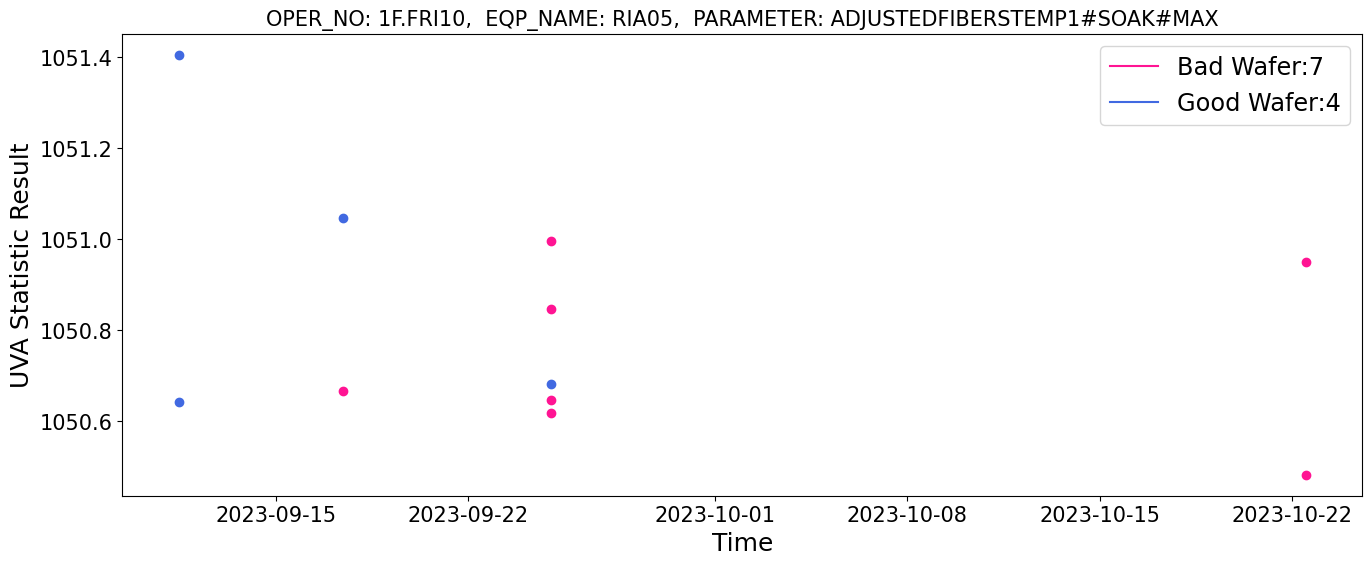

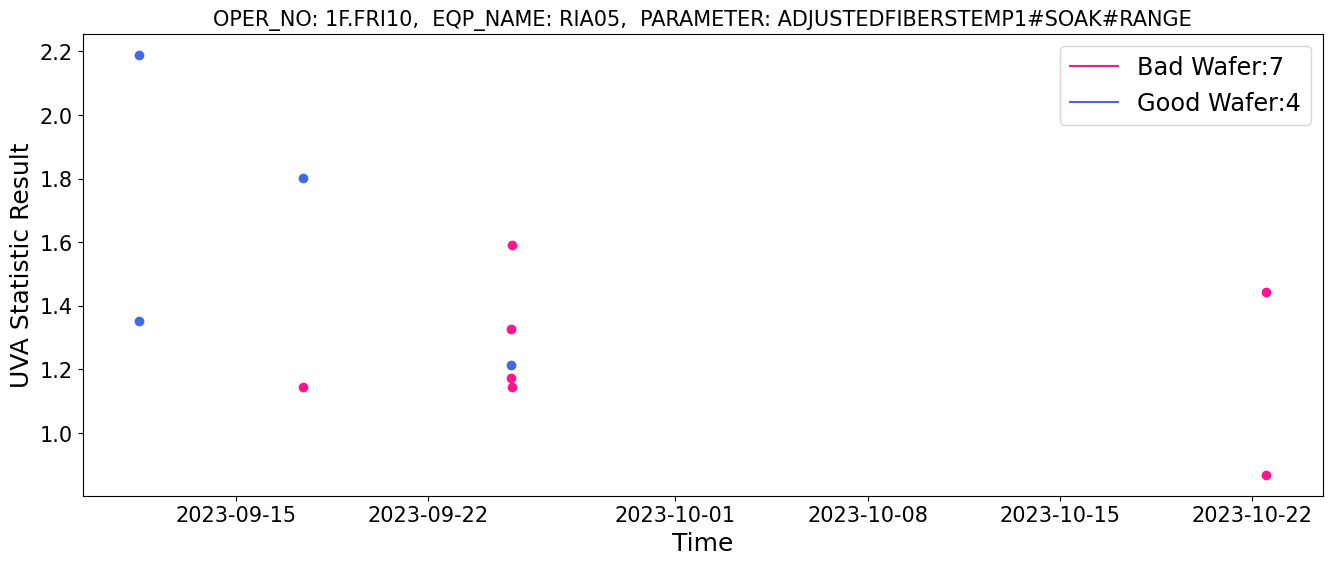

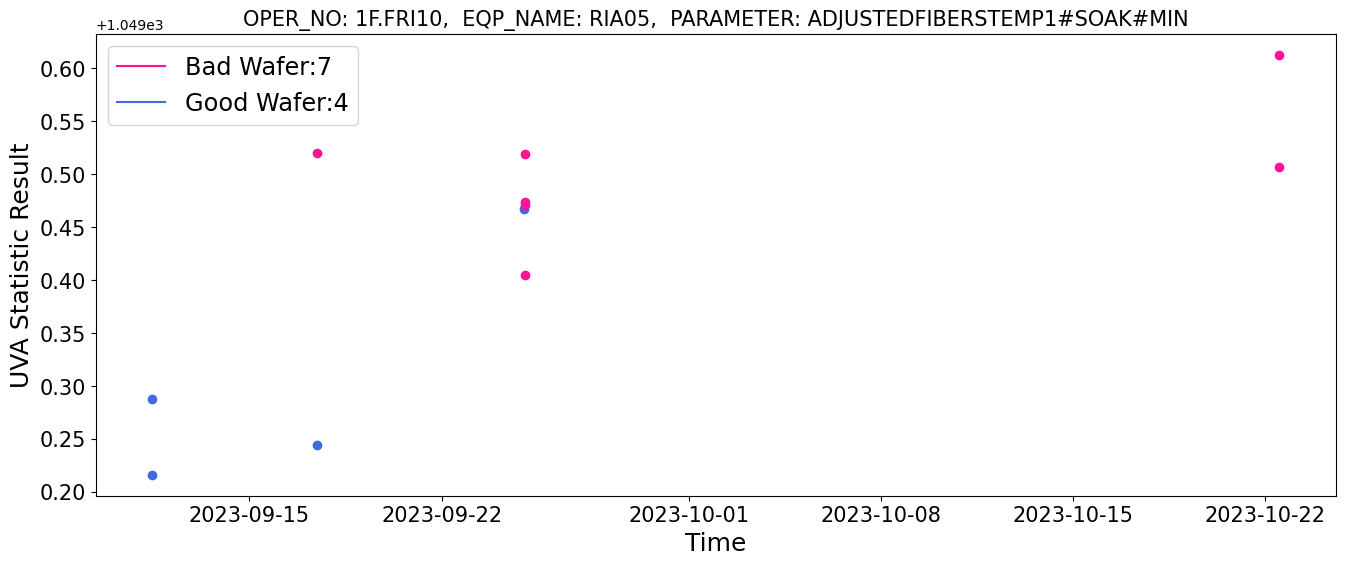

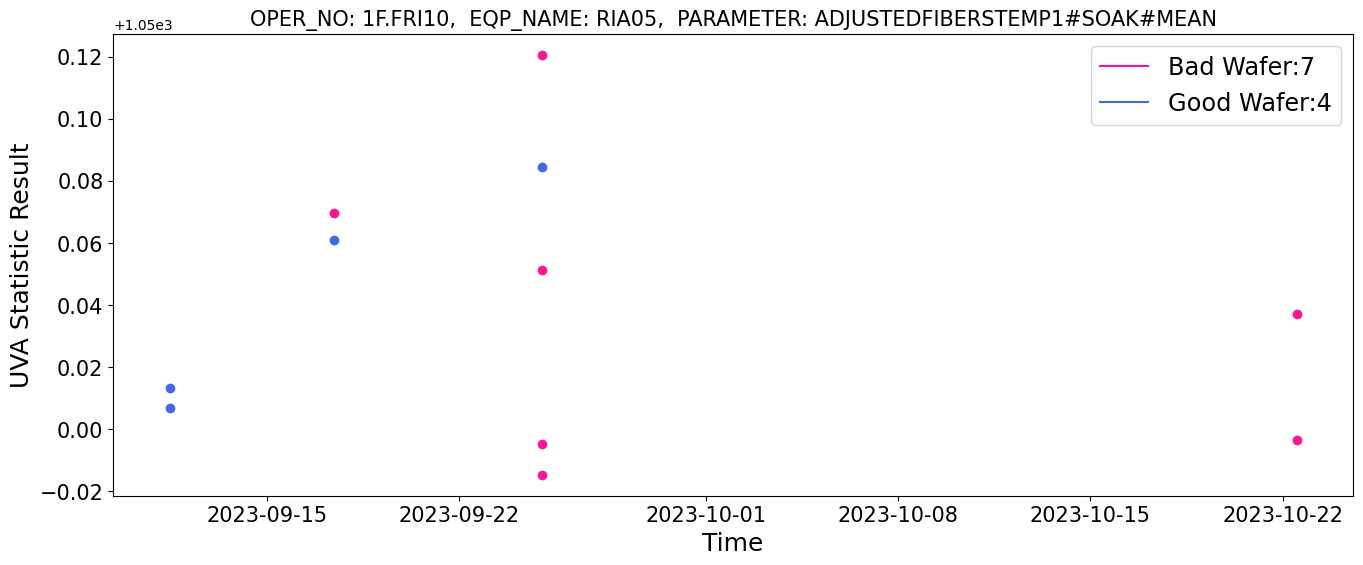

In [111]:
uva_data_certain_params_plot(df=df1_pandas_label, oper='1F.FRI10', tool='RIA05', param='ADJUSTEDFIBERSTEMP1#SOAK')

['HRF_POWER#DEP02#MEAN' 'HRF_POWER#DEP02#RANGE']


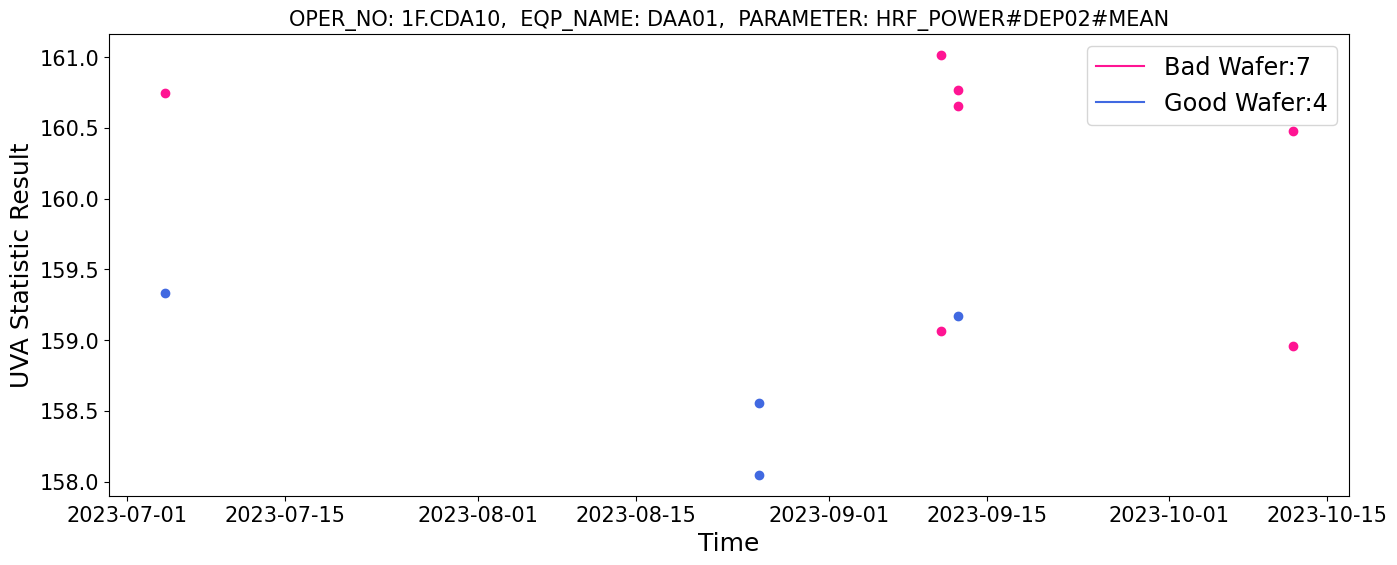

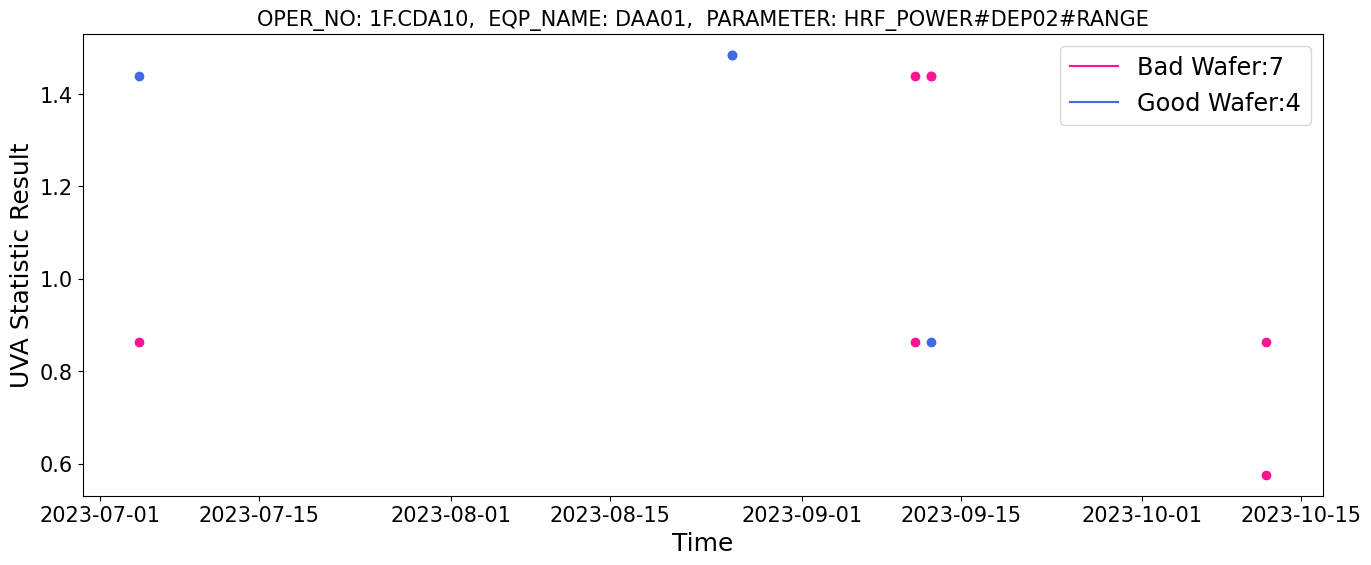

['ADJUSTEDFIBERSTEMP7#SOAK#RANGE' 'ADJUSTEDFIBERSTEMP7#SOAK#MEAN'
 'ADJUSTEDFIBERSTEMP7#SOAK#MIN' 'ADJUSTEDFIBERSTEMP7#SOAK#MAX']


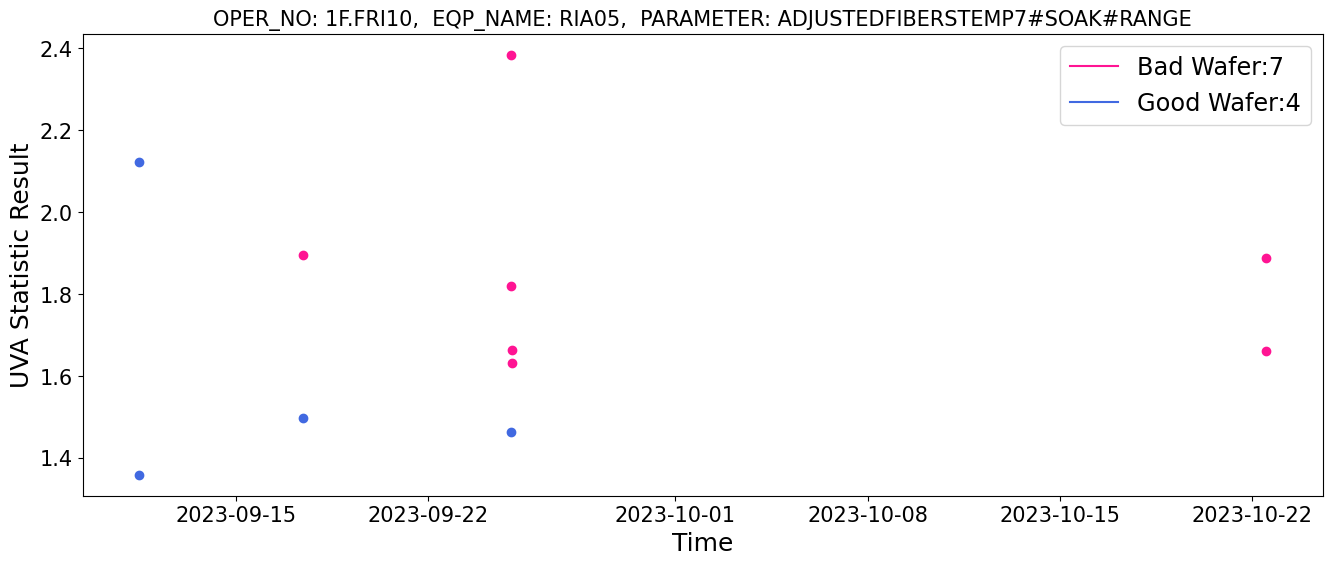

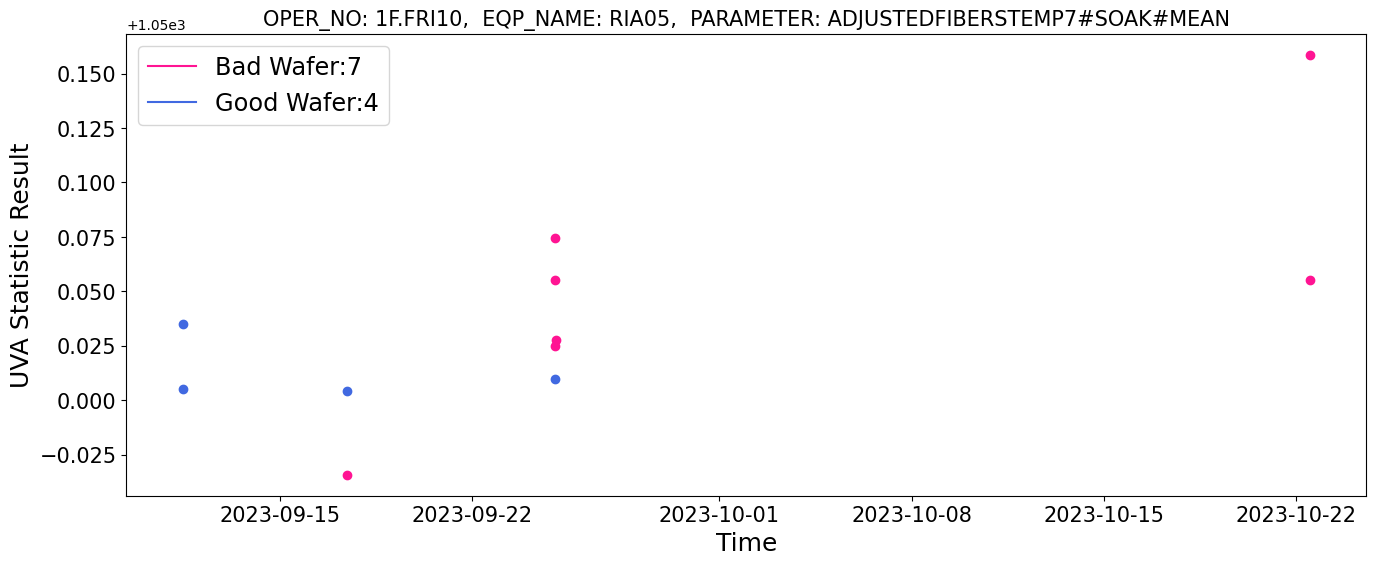

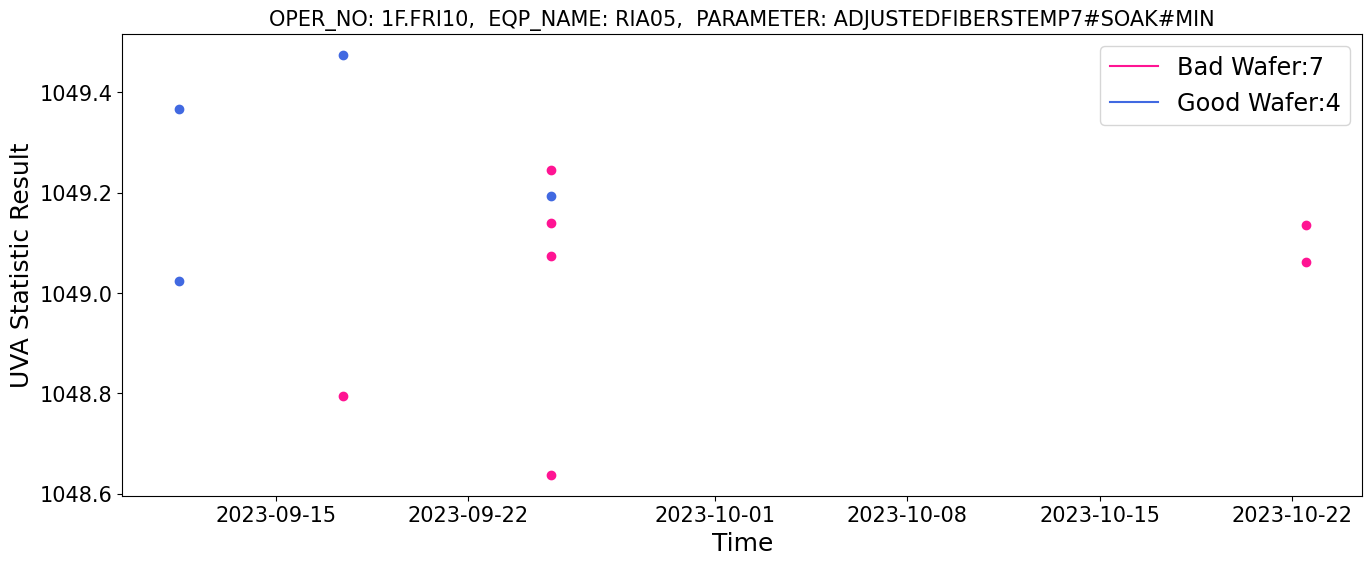

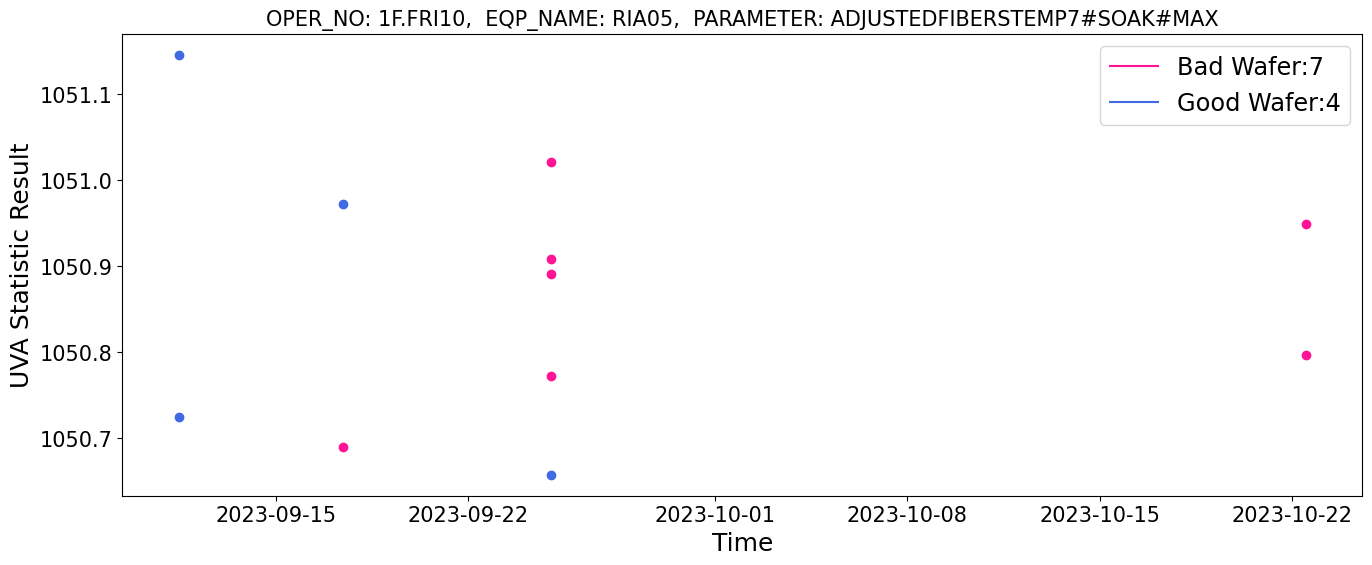

['ADJUSTEDFIBERSTEMP1#SOAK#MAX' 'ADJUSTEDFIBERSTEMP1#SOAK#RANGE'
 'ADJUSTEDFIBERSTEMP1#SOAK#MIN' 'ADJUSTEDFIBERSTEMP1#SOAK#MEAN']


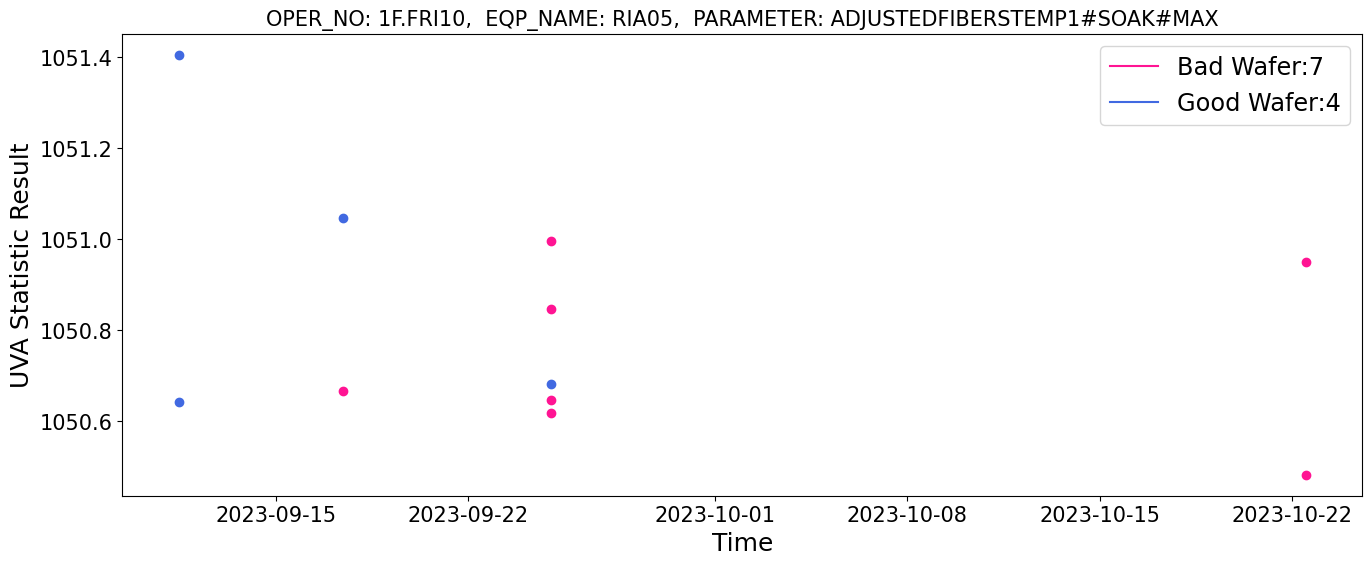

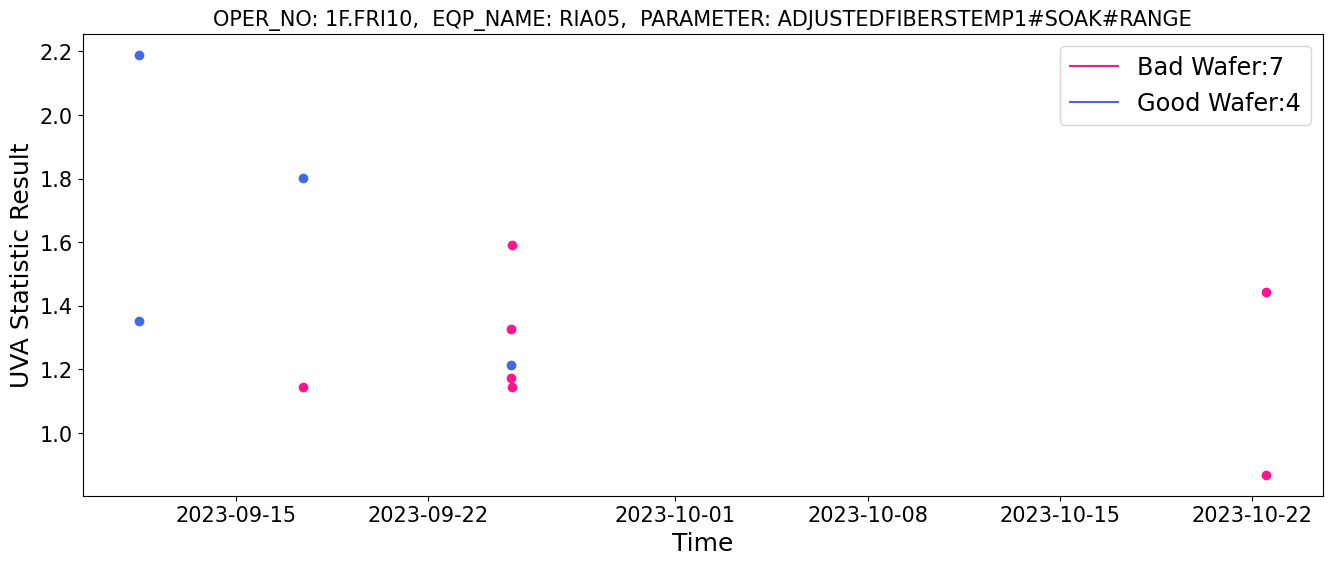

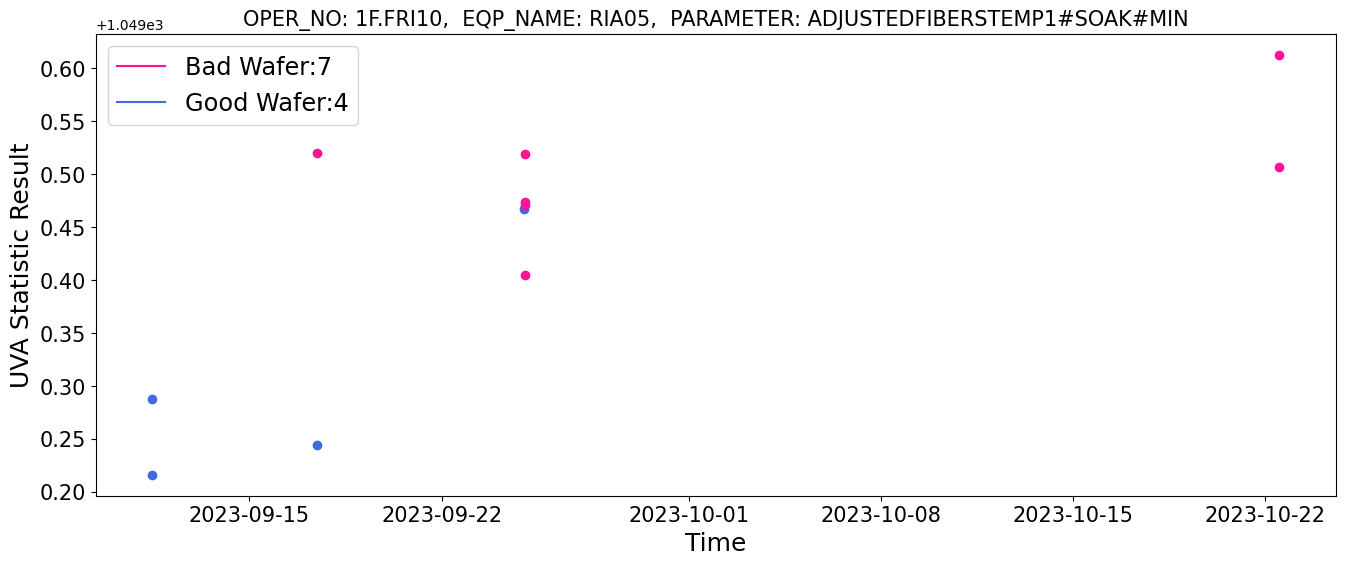

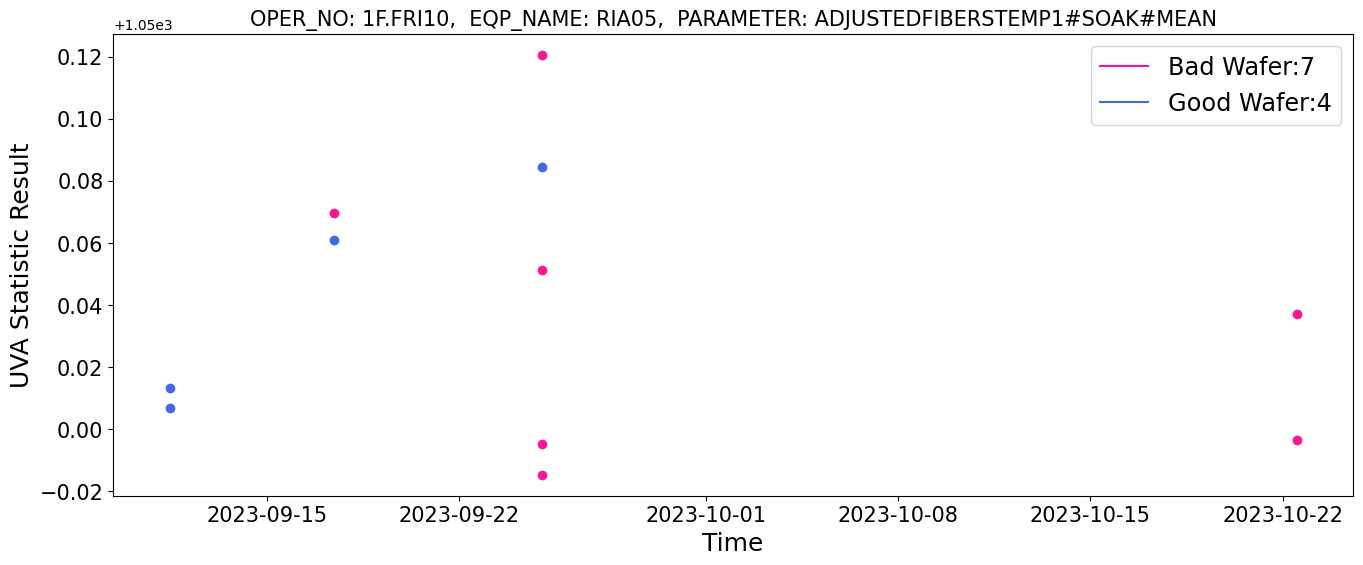

['WAFER_IDLER_SPEED#AUTO_STEP_NO_1#MEAN'
 'WAFER_IDLER_SPEED#AUTO_STEP_NO_1#MAX'
 'WAFER_IDLER_SPEED#AUTO_STEP_NO_1#MIN'
 'WAFER_IDLER_SPEED#AUTO_STEP_NO_1#RANGE']


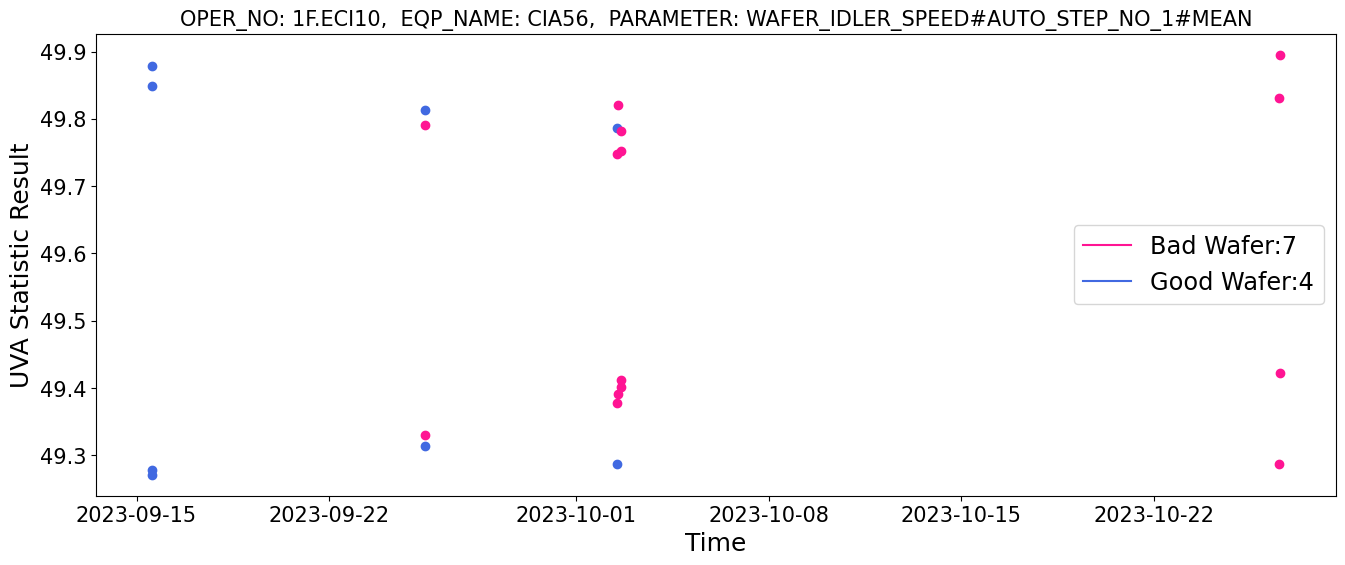

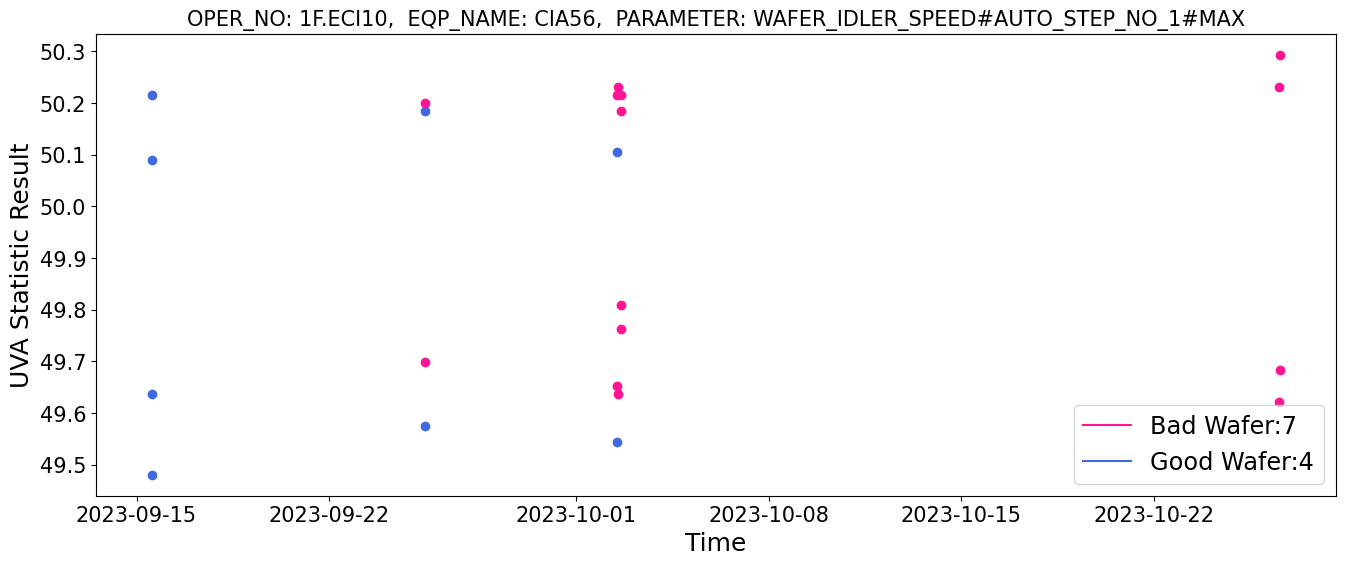

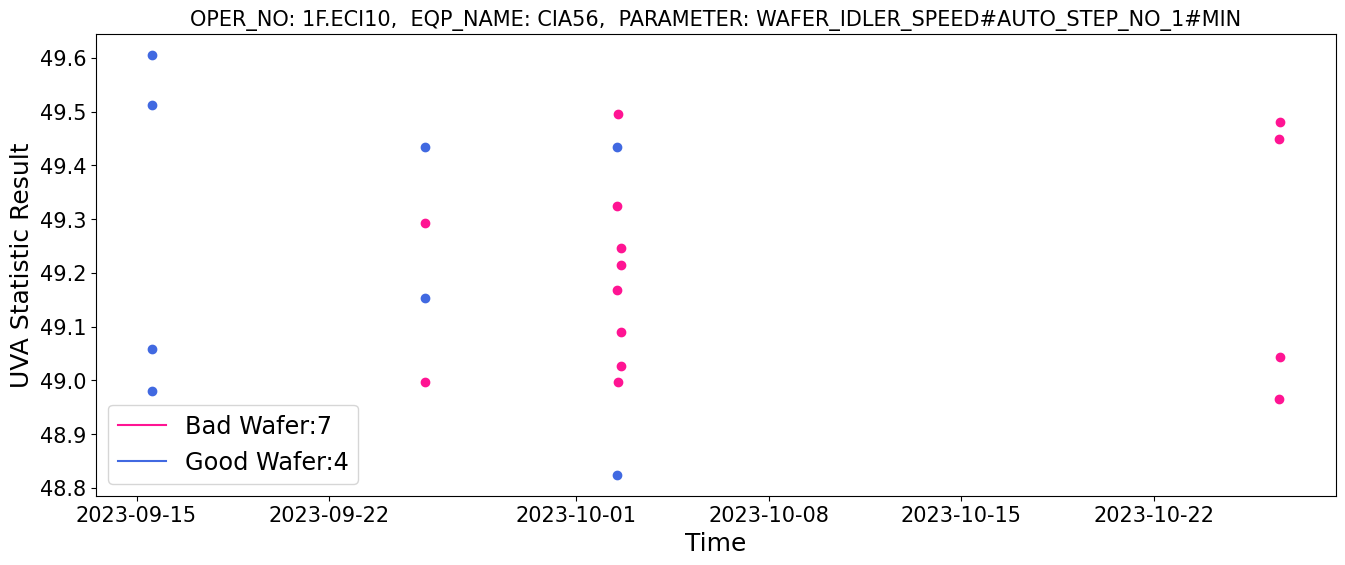

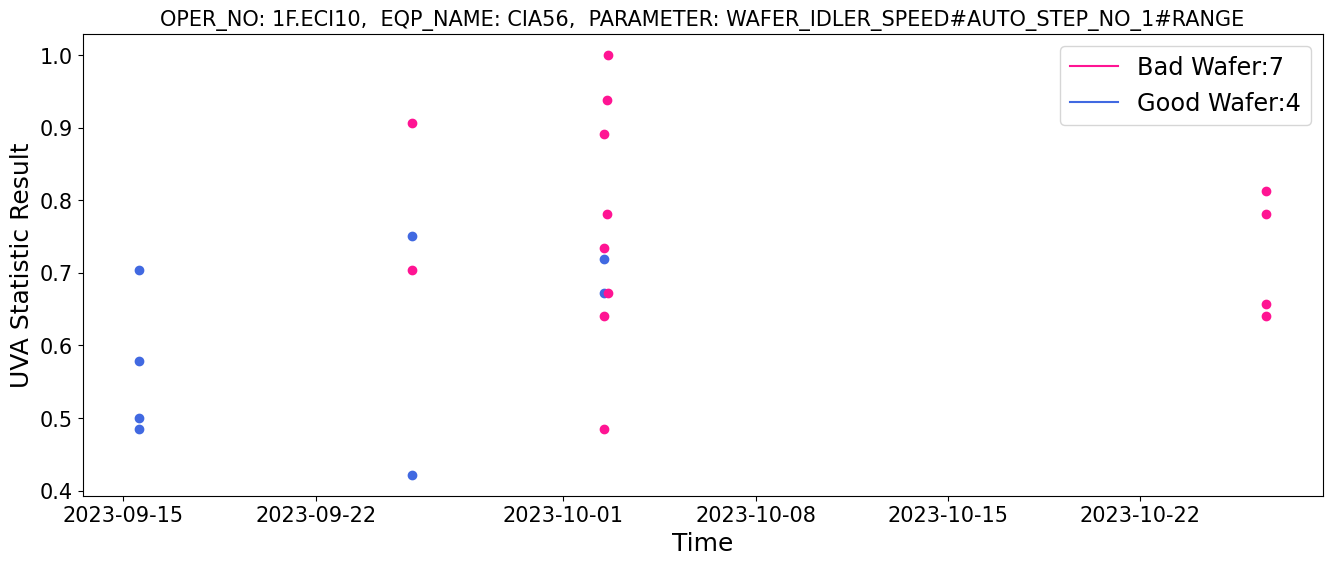

['SLURRY_FLOW_RATE1#AUTO_STEP_NO_1_5#MIN'
 'SLURRY_FLOW_RATE1#AUTO_STEP_NO_1_5#MEAN'
 'SLURRY_FLOW_RATE1#AUTO_STEP_NO_1_5#MAX'
 'SLURRY_FLOW_RATE1#AUTO_STEP_NO_1_5#RANGE']


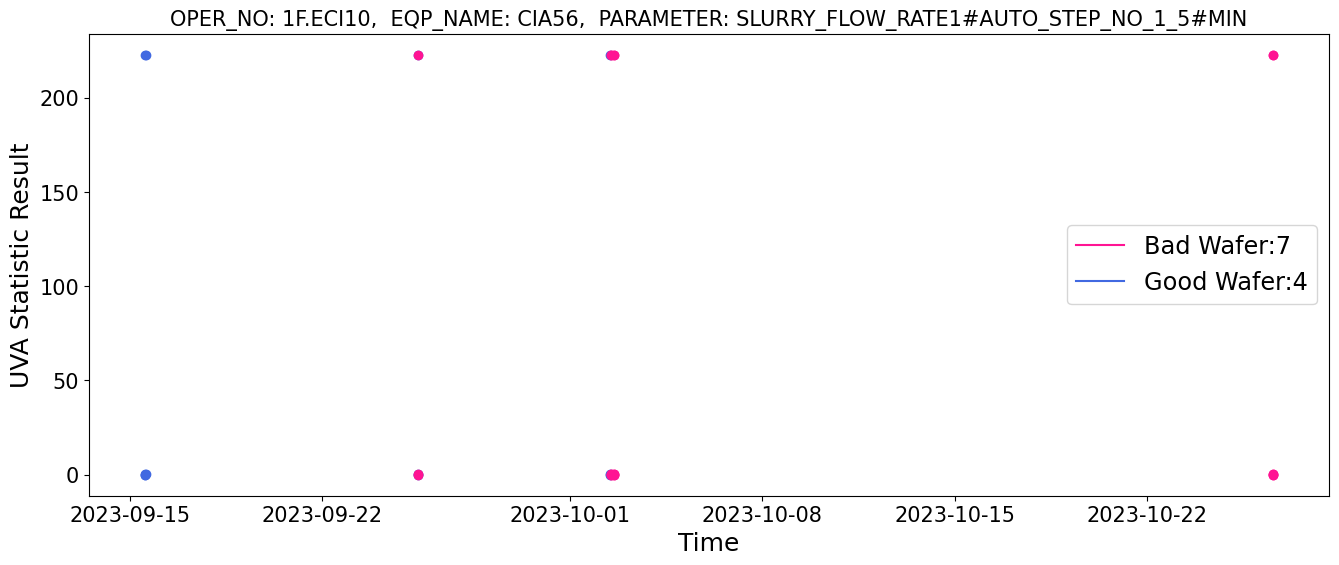

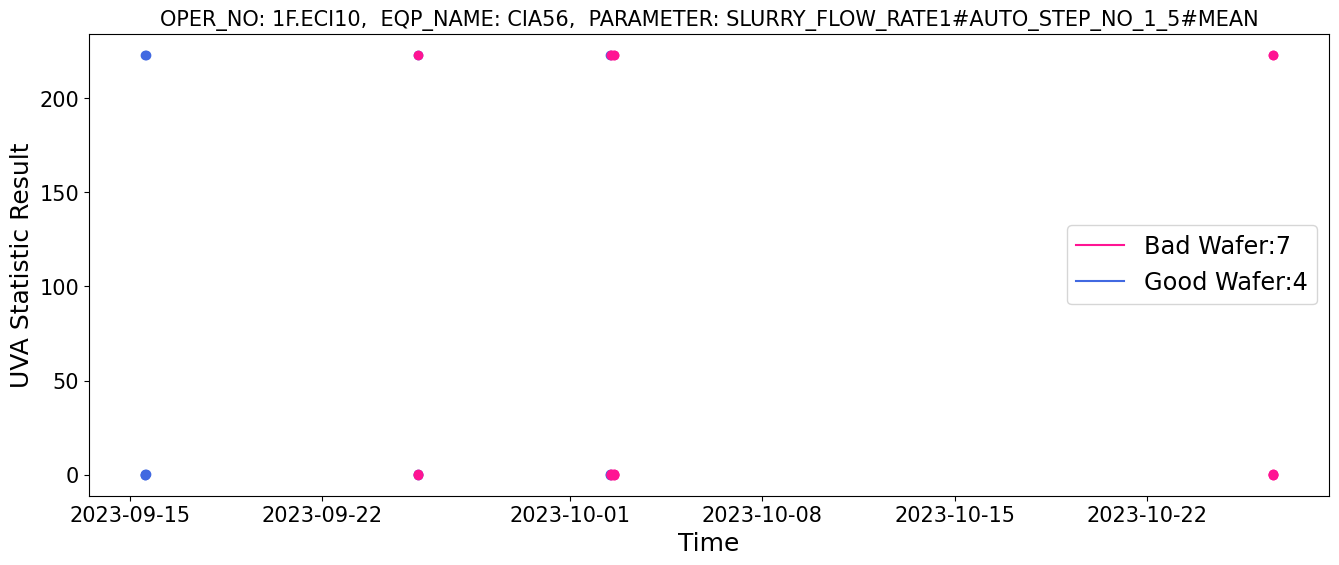

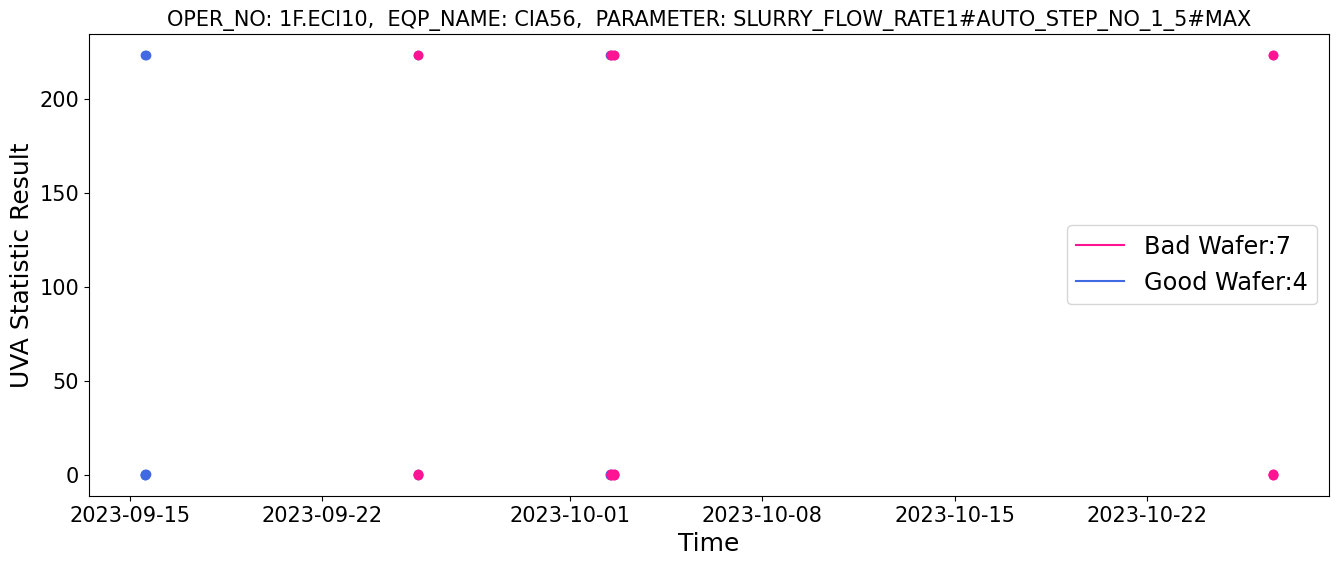

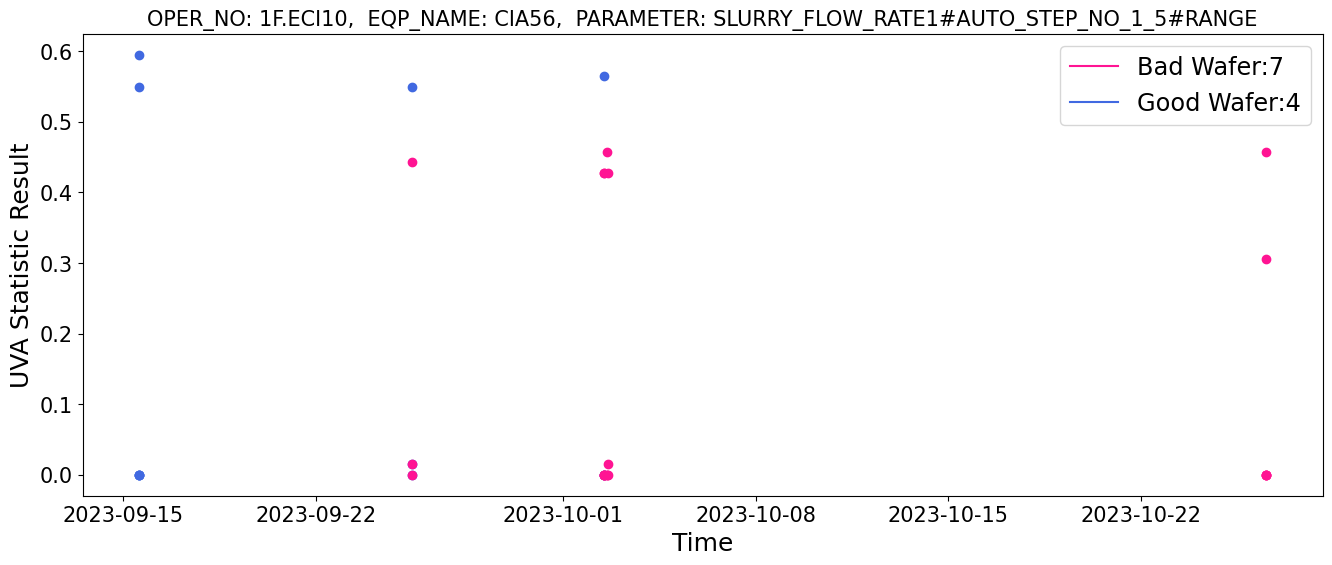

['HRF_POWER#HRF_POWER_STEP3_5#RANGE' 'HRF_POWER#HRF_POWER_STEP3_5#MEAN']


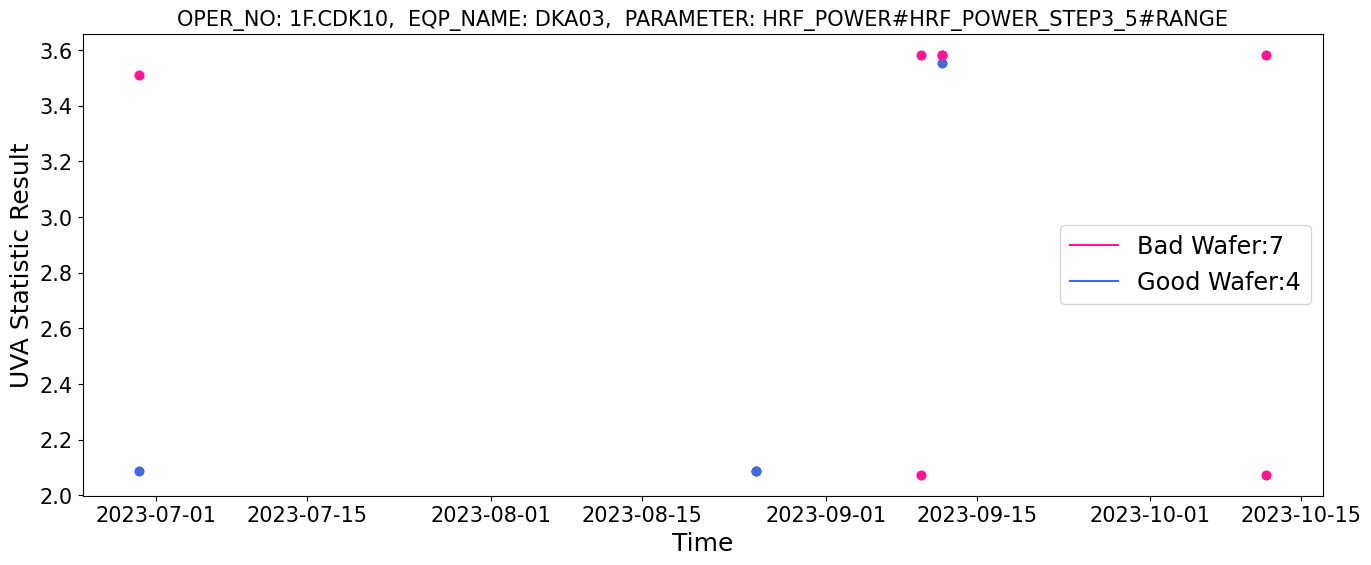

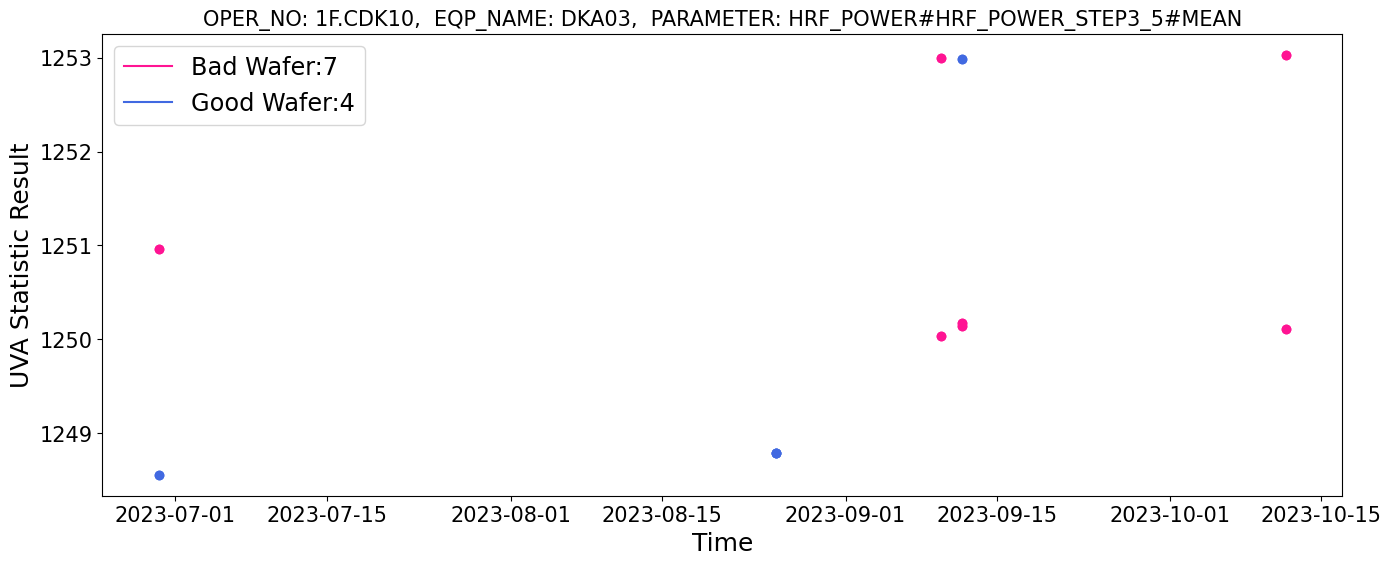

['ADJUSTEDFIBERSTEMP4#SOAK#MIN' 'ADJUSTEDFIBERSTEMP4#SOAK#RANGE'
 'ADJUSTEDFIBERSTEMP4#SOAK#MEAN' 'ADJUSTEDFIBERSTEMP4#SOAK#MAX']


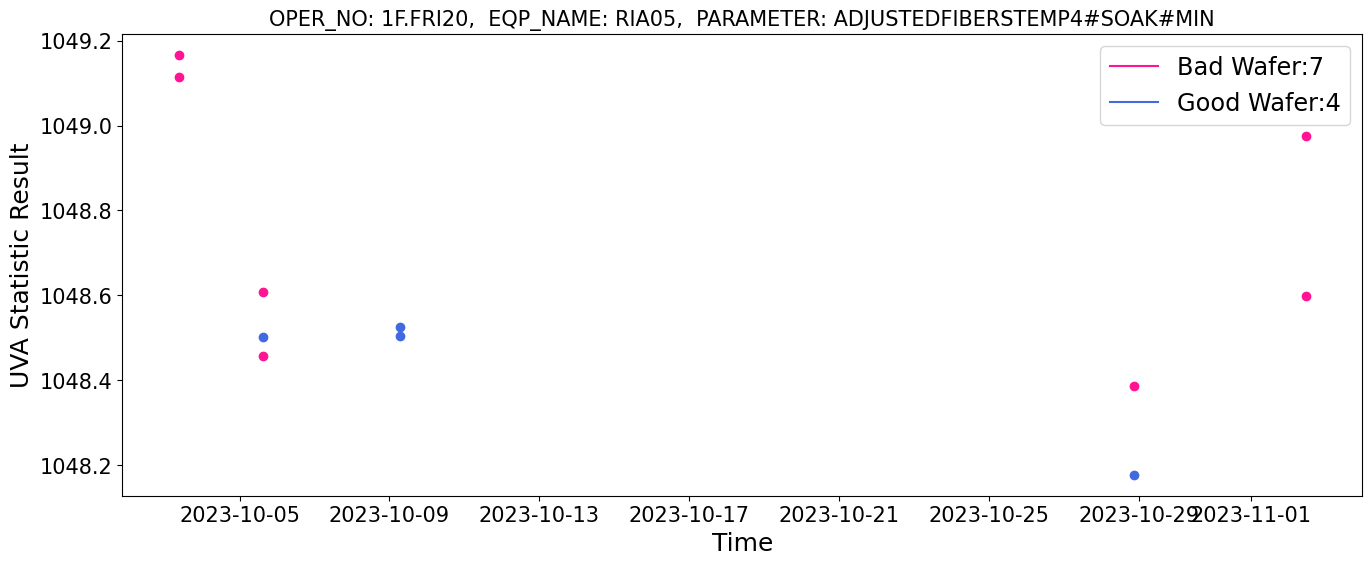

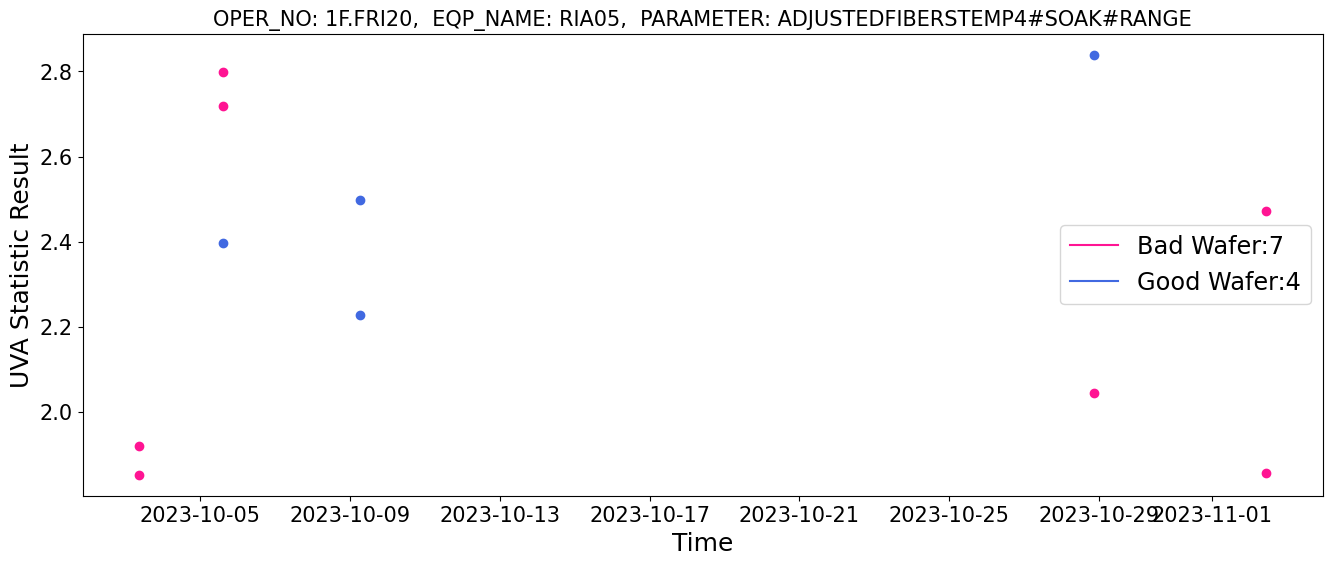

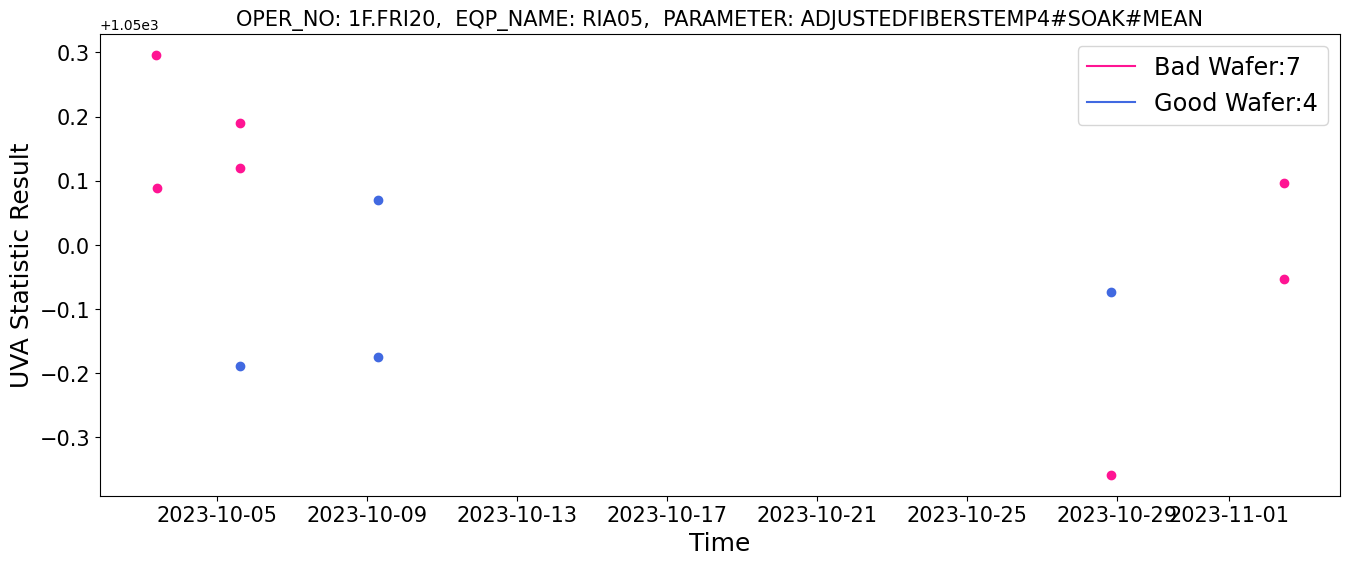

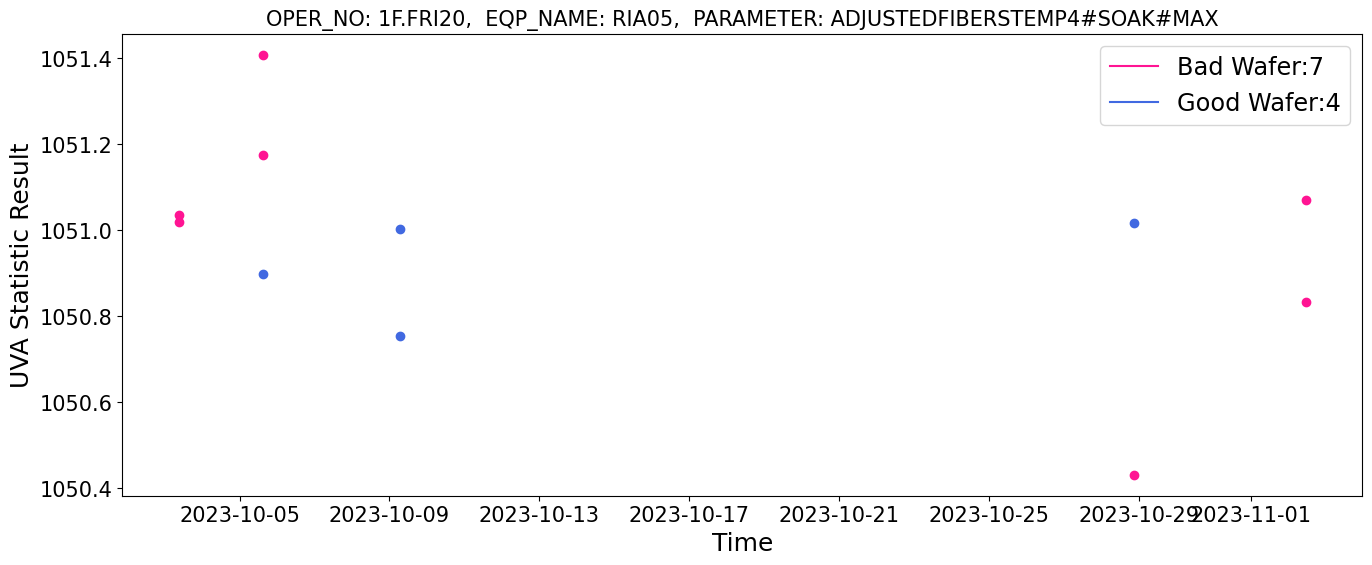

['THROTTLEVALVE_POSITION#DEP01#RANGE' 'THROTTLEVALVE_POSITION#DEP01#MEAN']


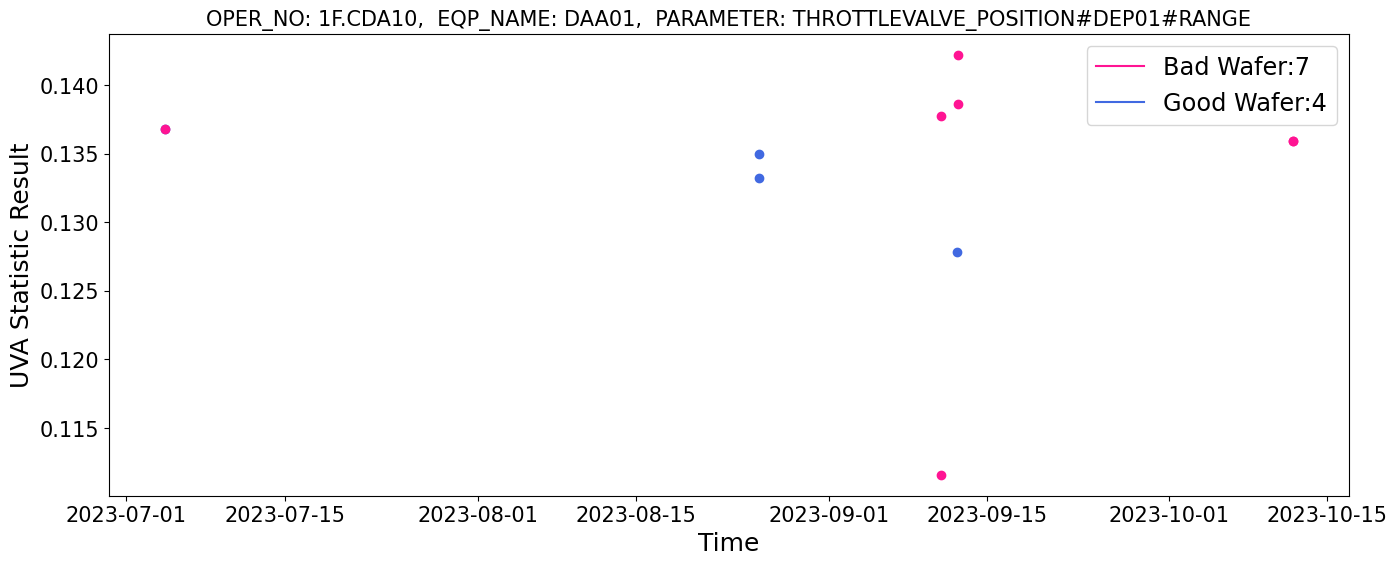

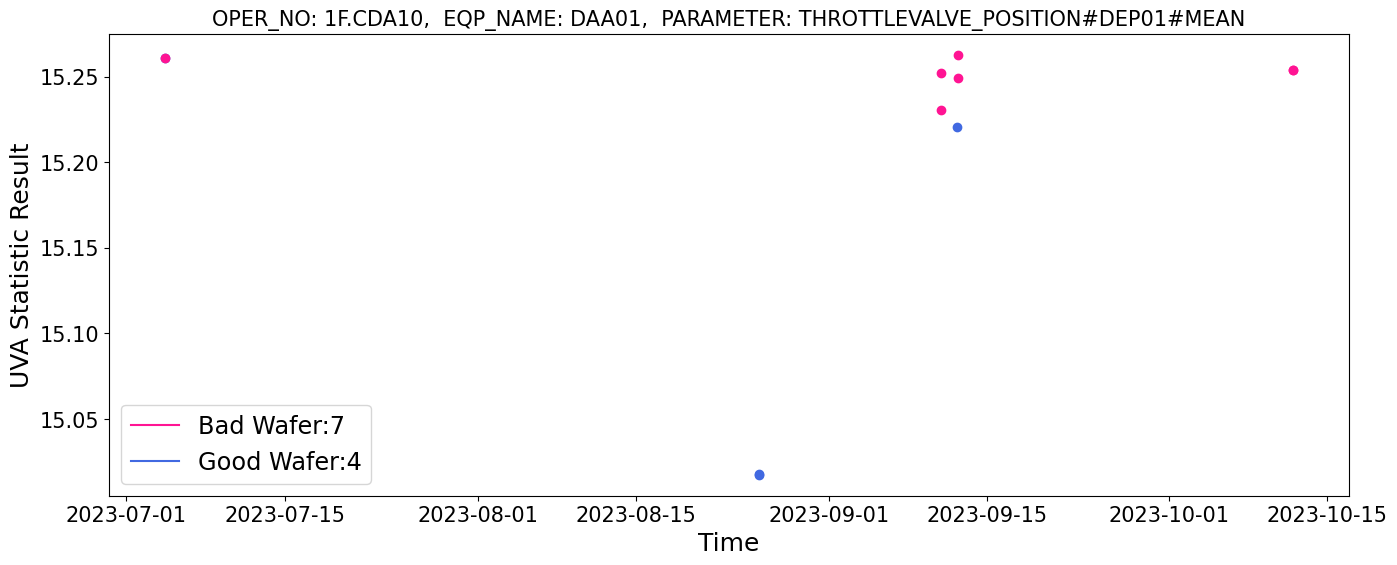

['ADJUSTEDFIBERSTEMP3#SOAK#MEAN' 'ADJUSTEDFIBERSTEMP3#SOAK#MAX'
 'ADJUSTEDFIBERSTEMP3#SOAK#MIN' 'ADJUSTEDFIBERSTEMP3#SOAK#RANGE']


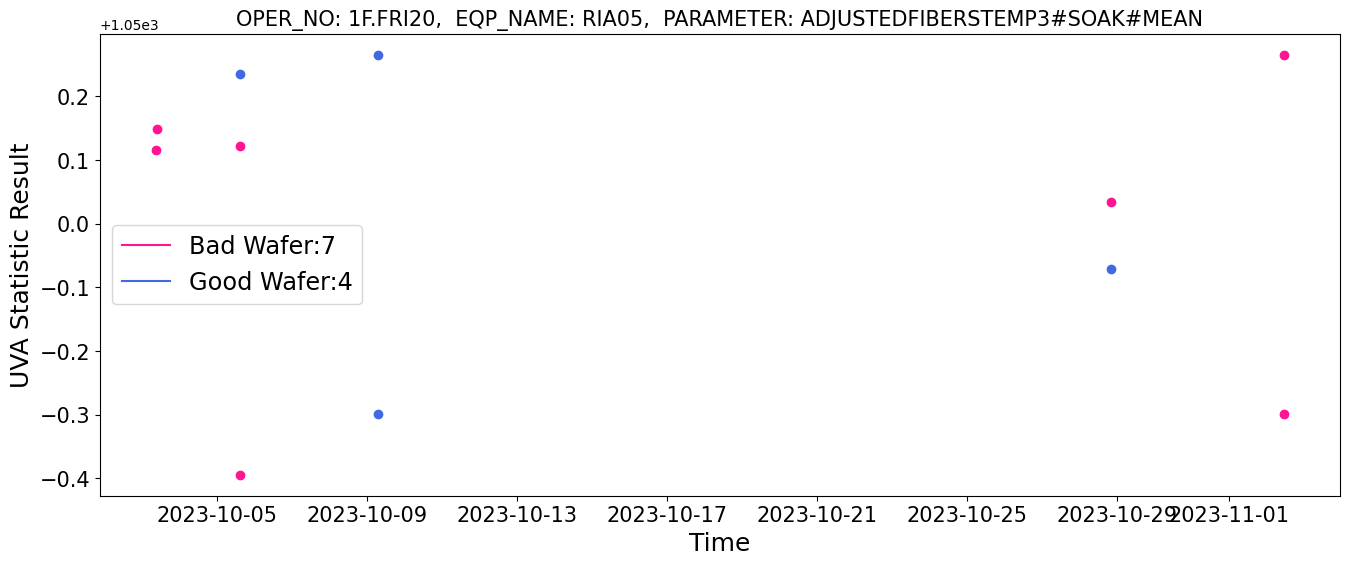

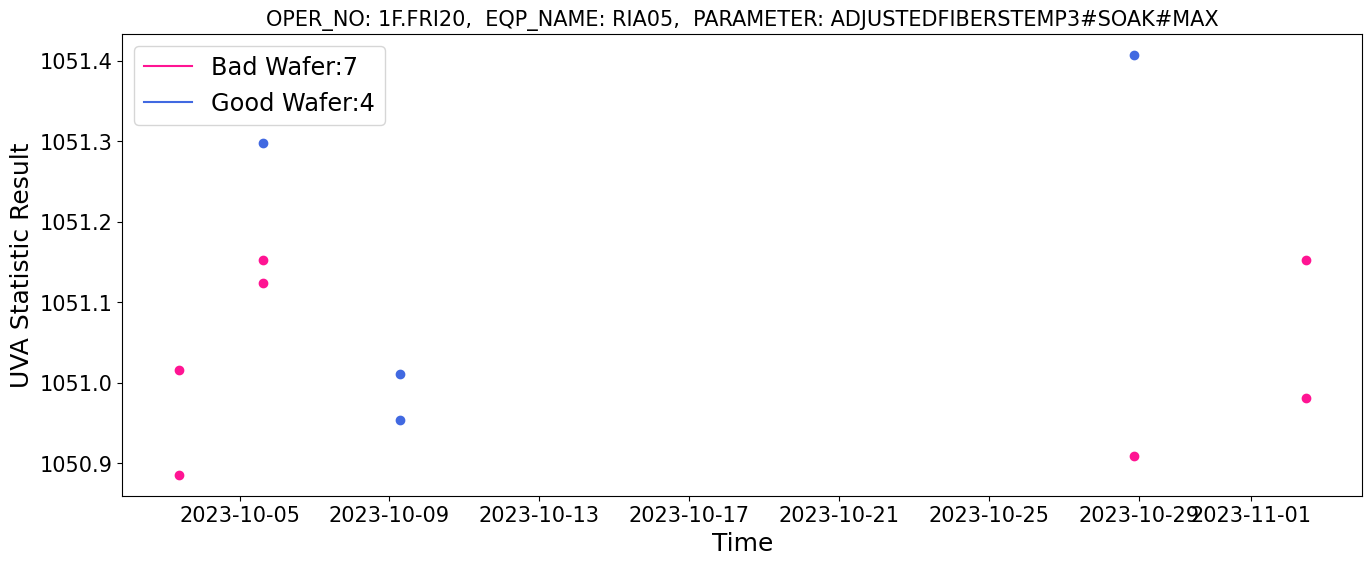

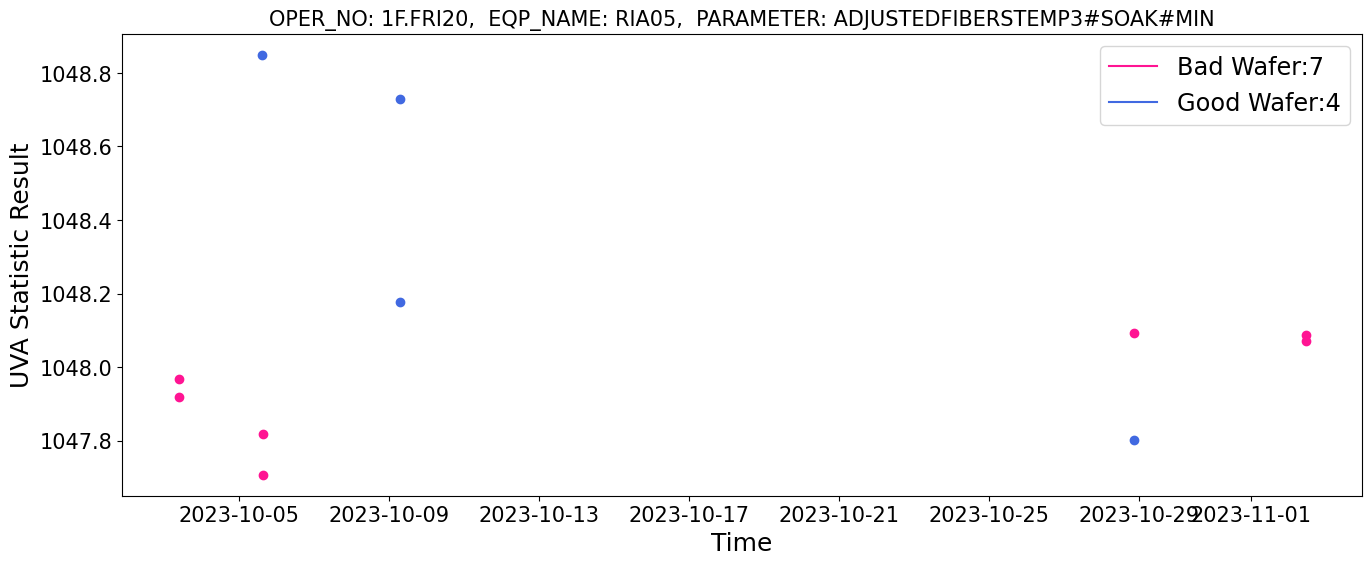

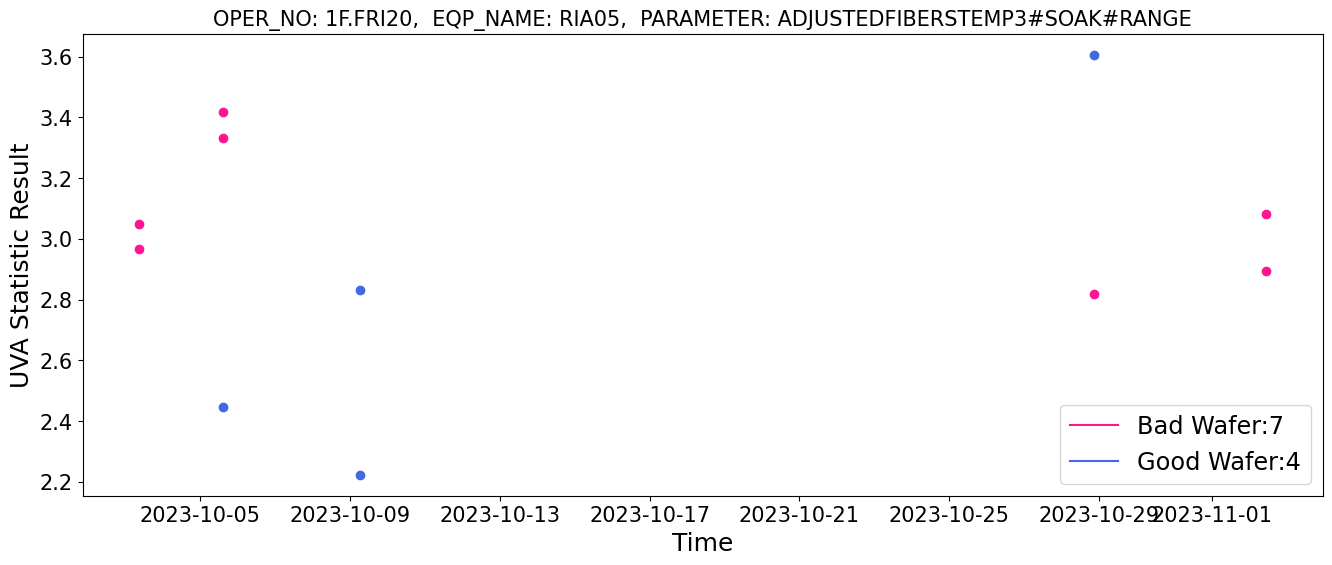

['ADJUSTEDFIBERSTEMP4#SOAK#RANGE' 'ADJUSTEDFIBERSTEMP4#SOAK#MAX'
 'ADJUSTEDFIBERSTEMP4#SOAK#MIN' 'ADJUSTEDFIBERSTEMP4#SOAK#MEAN']


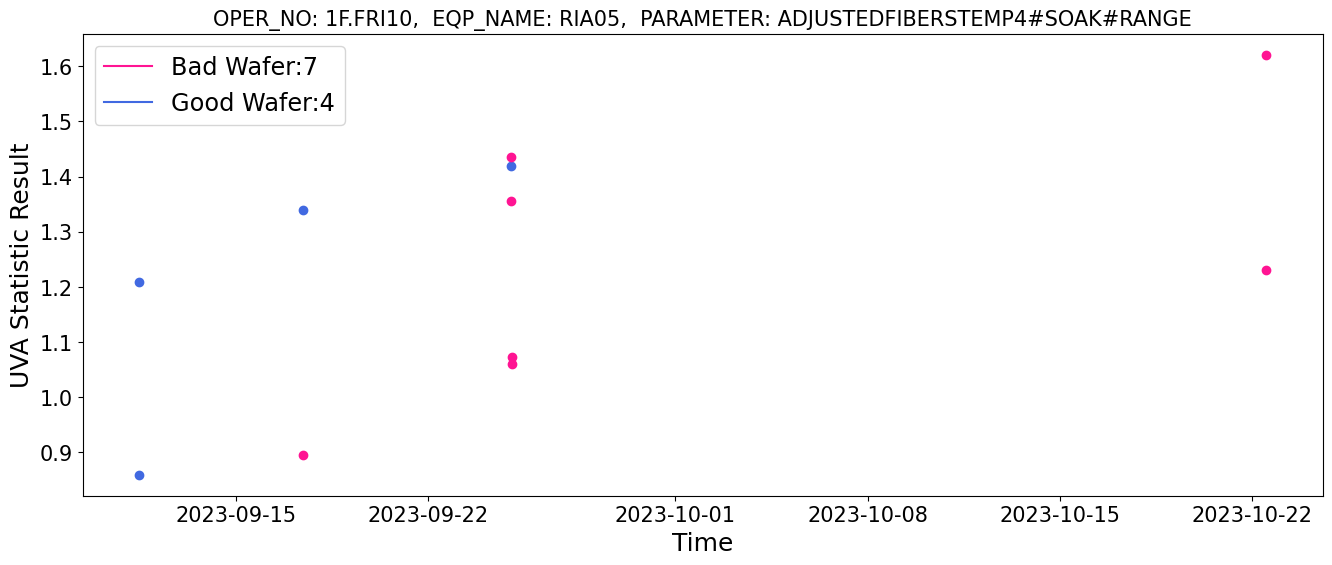

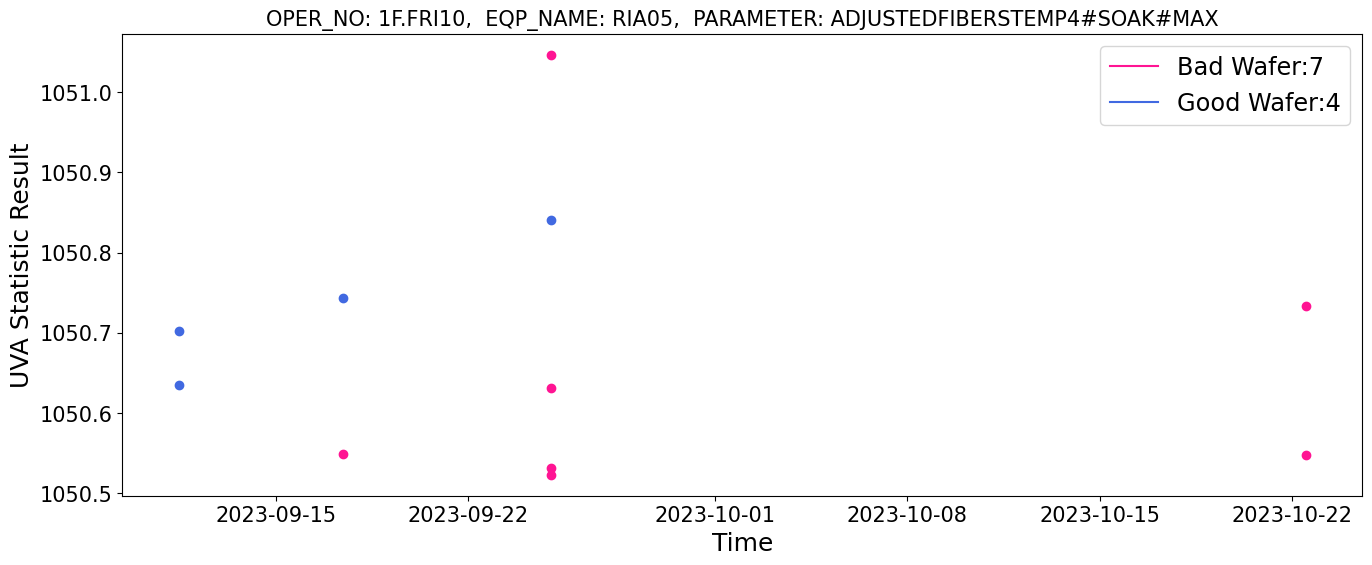

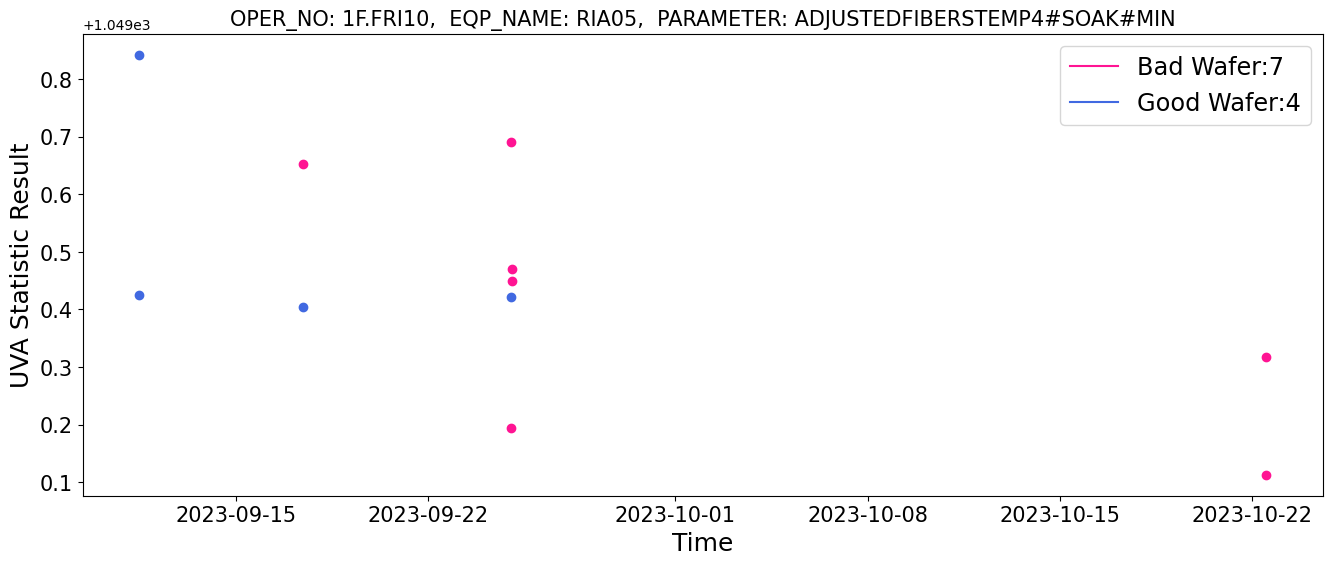

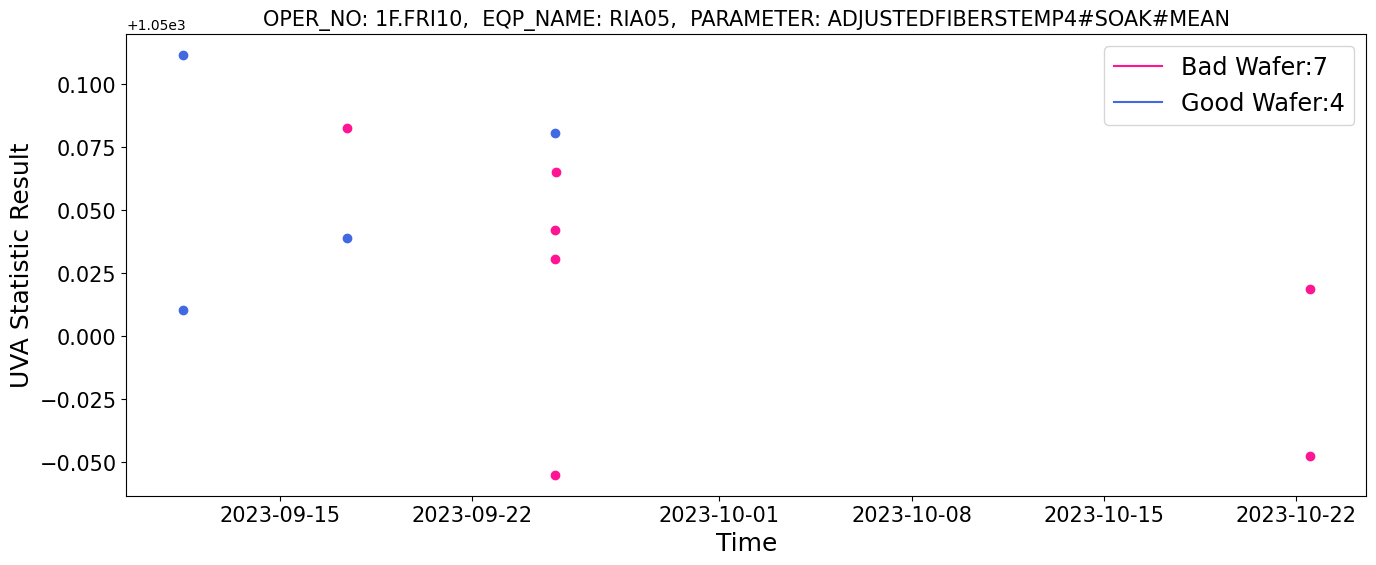

In [105]:
for i in range(len(res_dict)):
    uva_data_certain_params_plot(df=df1_pandas_label, oper=res_dict[i]['OPER_NO'], 
                                 tool=res_dict[i]['EQP_NAME'], param=res_dict[i]['parametric_name'])